# Chargement des Bibliothèques

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer,AutoConfig,AutoTokenizer,pipeline, AutoModelForSequenceClassification,EarlyStoppingCallback
from datasets import load_metric
import torch

import re

from wordcloud import WordCloud

from tqdm import tqdm
import html
import fasttext
from torch.utils.data import Dataset
import time


/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Chargement et Analyse Préliminaire des Données

In [2]:
data = pd.read_csv("data/RAW/training.1600000.processed.noemoticon.csv",names=["target", "id", "date", "query", "user", "text"], encoding='ISO-8859-1')

## Chargement des Données 

## Aperçu des Données

In [3]:
data.head()

,target,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
data['target'] = data['target'].apply(lambda x: 1 if x == 4 else 0)

### Distribution des Sentiments

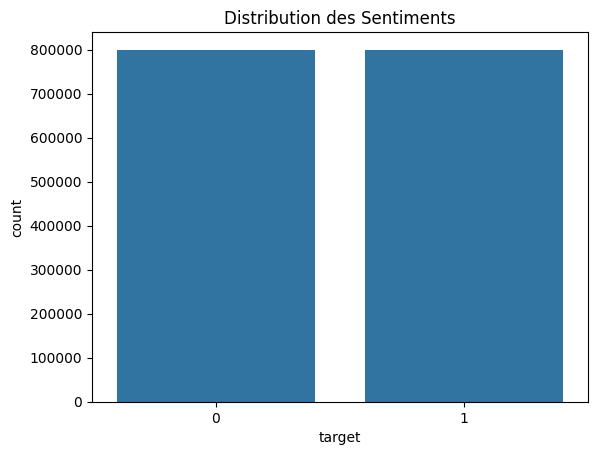

In [5]:
sns.countplot(x='target', data=data)
plt.title('Distribution des Sentiments')
plt.show()

1. **Équilibre entre les classes** : Les deux classes de sentiments représentées par `0` et `4` sont presque parfaitement équilibrées. Cela signifie que l'ensemble de données contient un nombre presque égal de tweets ou de textes étiquetés comme sentiment négatif (0) et sentiment positif (4).
  
2. **Absence de classes intermédiaires** : Le graphique ne montre que deux classes (`0` et `4`), ce qui suggère que cet ensemble de données est binaire, c'est-à-dire qu'il ne classe les sentiments qu'en deux catégories : positifs et négatifs. Il n'y a pas de classe représentant un sentiment neutre ou d'autres types de sentiments.

L'équilibre des classes est un aspect positif pour la modélisation, car cela signifie que le modèle n'aura pas à compenser un déséquilibre dans les données. Un ensemble de données équilibré permet souvent d'obtenir des modèles plus robustes.

### Analyse des Mots

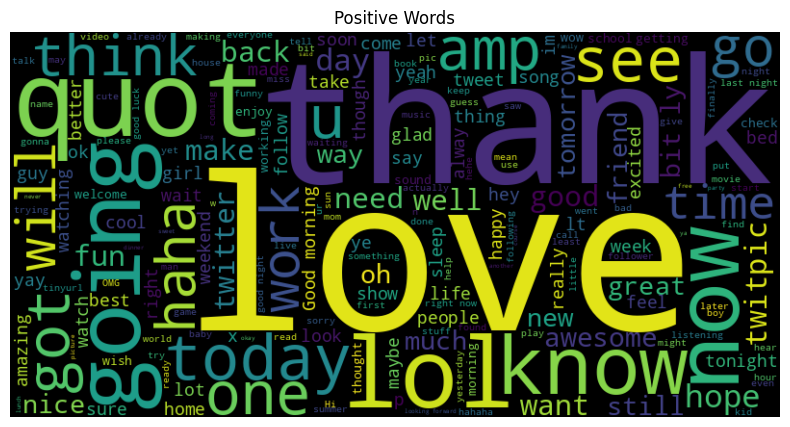

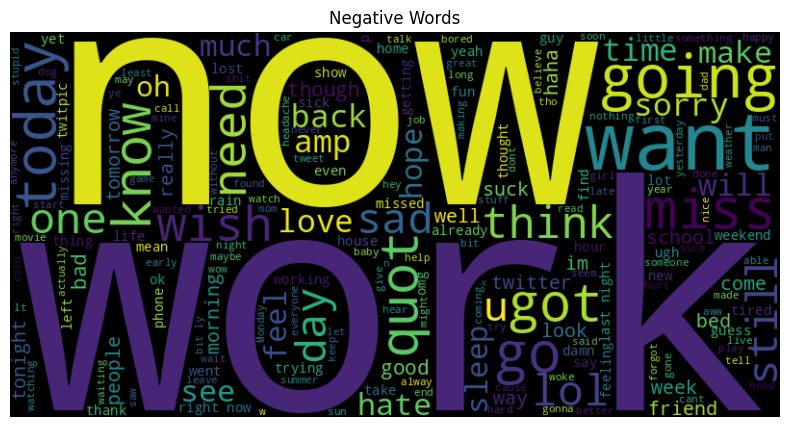

In [6]:
# Nuage de mots pour chaque classe de sentiment
positive_words = ' '.join(data[data['target'] == 1]['text'])
negative_words = ' '.join(data[data['target'] == 0]['text'])

wordcloud_positive = WordCloud(width=800, height=400).generate(positive_words)
wordcloud_negative = WordCloud(width=800, height=400).generate(negative_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Words')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Words')
plt.show()

### Nuage de mots des termes positifs :
- **Mots dominants** : Les mots "thank", "love", "lol", "going", et "today" sont parmi les plus fréquemment utilisés dans les textes associés aux sentiments positifs. Ces termes suggèrent des expressions de gratitude ("thank"), d'affection ou de satisfaction ("love"), et d'humour ("lol").
- **Connotations** : Les mots comme "awesome", "good", "happy", "fun", et "yay" renforcent l'idée que ces textes expriment des émotions positives, de la satisfaction, et de la joie.
- **Contextes sociaux** : Les mots comme "friend", "hope", "cool", et "excited" montrent que beaucoup de ces textes positifs sont probablement liés à des interactions sociales, à des espoirs pour l'avenir, et à des moments agréables.

### Nuage de mots des termes négatifs :
- **Mots dominants** : Les mots "work", "now", "want", "going", et "back" sont les plus fréquents dans les textes associés aux sentiments négatifs. Le terme "work" est particulièrement prédominant, ce qui suggère que le travail est une source fréquente de stress ou d'insatisfaction.
- **Connotations** : Des termes comme "sad", "hate", "suck", "miss", et "wish" indiquent des émotions négatives, telles que la tristesse, le regret, et le mécontentement.
- **Thèmes récurrents** : Le fait que "work", "miss", et "need" soient si proéminents peut indiquer des préoccupations liées au travail, à la perte ou à l'absence de quelque chose ou de quelqu'un, ainsi qu'à des besoins insatisfaits.

### Longueur des Tweets

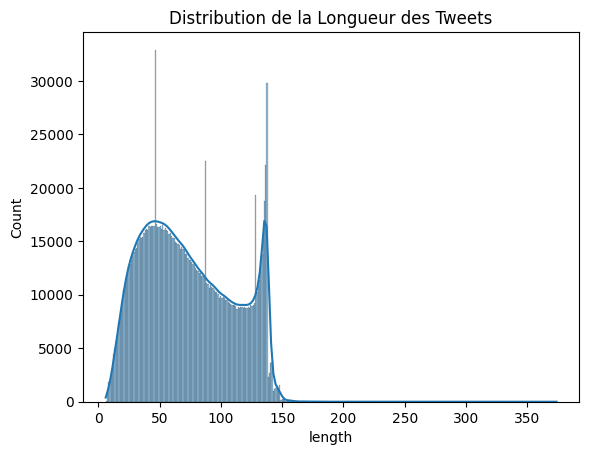

In [7]:
data['length'] = data['text'].apply(len)
sns.histplot(data['length'], kde=True)
plt.title('Distribution de la Longueur des Tweets')
plt.show()

1. **Pic principal autour de 50-100 caractères** : La distribution montre un premier pic significatif dans la plage de 50 à 100 caractères. Cela indique que beaucoup de tweets dans cet ensemble de données ont une longueur modérée, ce qui est cohérent avec la nature concise et brève des tweets sur Twitter.

2. **Deuxième pic autour de 140-150 caractères** : Il y a un autre pic marqué autour de 140-150 caractères, qui représente le nombre maximum de caractères permis par Twitter à l'époque où ces tweets ont été collectés (avant que la limite de caractères ne soit augmentée à 280). Cela signifie que de nombreux utilisateurs utilisaient au maximum la longueur autorisée pour exprimer leurs idées.

3. **Longueur minimale et maximale** :
   - **Longueur minimale** : Très peu de tweets sont extrêmement courts (moins de 20 caractères).
   - **Longueur maximale** : Très peu de tweets dépassent la limite historique de 140 caractères (bien que certains puissent être des retweets ou contiennent des éléments comme des liens ou des hashtags longs).

4. **Présence d'une queue à droite** : Bien qu'il y ait une concentration de tweets plus courts, il existe une longue traîne vers des tweets plus longs, mais leur fréquence est nettement plus faible. Cette queue représente les tweets qui utilisent plus de caractères, mais ils restent relativement rares.

In [8]:
def decode_html_entities(text):
    return html.unescape(text)

# Appliquer la fonction à la colonne de texte
data['text'] = data['text'].apply(decode_html_entities)

# Vérifier le résultat sur un exemple
example_text = "wwh babs... you look so sad underneith that shop entrance of &quot;Yesterday's Musik&quot;  O-: I like the look of the new transformer movie"
cleaned_text = decode_html_entities(example_text)
display(cleaned_text) 

'wwh babs... you look so sad underneith that shop entrance of "Yesterday\'s Musik"  O-: I like the look of the new transformer movie'

In [9]:
data['date'] = pd.to_datetime(data['date'], errors='coerce')

display(data['date'].max())

/tmp/ipykernel_2490986/2980465349.py:1: FutureWarning: Parsed string "Mon Apr 06 22:19:45 PDT 2009" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  data['date'] = pd.to_datetime(data['date'], errors='coerce')


Timestamp('2009-06-25 10:28:31')

In [10]:
display(data['length'].max())

374

In [11]:
long_tweets = data[data['length'] > 150]
display(long_tweets[['text', 'length']])

,text,length
1767,"tks pa 4 ""tapauing"" croissant tuna knowing dat...",152
3434,@danielhcwong Taylor 814ce --> #&$(#&$!(@#$(!@...,157
6894,"Woke up early this morning to ""not all the way...",158
13538,"Took niece & nephew to Blockbuster- rented ""Ma...",167
16809,@SongzYuuup wat is the name of ur mixtape with...,161
...,...,...
1597295,#140conf Smartarse with an average look or gud...,151
1597559,"@antiprism ""So Dan, u want JIRA for the dev te...",188
1598103,Finally! The Space Ð¡akes are on Twitter! Welc...,178
1598718,"I asked a 3yr old how old I was & he said, ""3 ...",158


In [12]:
data = data[data['length'] <= 150]

In [13]:
display(data['length'].max())

150

### Longueur des Tweets en fonction du sentiment

In [14]:
# Ajouter une nouvelle colonne 'length' qui contient la longueur de chaque tweet
data['length'] = data['text'].apply(len)

# Définir les intervalles de longueur (paliers de 10 caractères)
bins = np.arange(0, data['length'].max() + 10, 10)

# Catégoriser les tweets selon les intervalles de longueur
data['length_bin'] = pd.cut(data['length'], bins=bins, right=False)

# Calculer le nombre de tweets positifs et négatifs pour chaque intervalle de longueur
length_distribution = data.groupby(['length_bin', 'target']).size().unstack(fill_value=0)

# Calculer les pourcentages
length_distribution_percent = length_distribution.div(length_distribution.sum(axis=1), axis=0) * 100

# Ajouter une colonne avec le nombre total de tweets pour chaque intervalle
length_distribution_percent['Total Tweets'] = length_distribution.sum(axis=1)

# Renommer les colonnes pour plus de clarté
length_distribution_percent = length_distribution_percent.rename(columns={0: 'Négatif (%)', 4: 'Positif (%)'})
length_distribution_percent.index.name = 'Intervalle de Longueur'
length_distribution_percent = length_distribution_percent.reset_index()

# Afficher le tableau
length_distribution_percent

/tmp/ipykernel_2490986/3361444708.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  length_distribution = data.groupby(['length_bin', 'target']).size().unstack(fill_value=0)


target,Intervalle de Longueur,Négatif (%),1,Total Tweets
0,"[0, 10)",64.062500,35.937500,3136
1,"[10, 20)",55.174864,44.825136,53470
2,"[20, 30)",49.367442,50.632558,121728
3,"[30, 40)",48.813892,51.186108,153696
4,"[40, 50)",48.849972,51.150028,165083
5,"[50, 60)",49.461236,50.538764,161852
6,"[60, 70)",49.623164,50.376836,149269
7,"[70, 80)",49.902859,50.097141,133311
8,"[80, 90)",49.525016,50.474984,117583
9,"[90, 100)",49.682585,50.317415,104910


- **Tweets très courts (0-20 caractères)** :
    - Les tweets les plus courts, en particulier ceux entre 0 et 10 caractères, montrent une prédominance des sentiments négatifs (56,67%). Cette tendance se réduit légèrement dans l'intervalle de 10 à 20 caractères, où les tweets négatifs représentent 53,91% du total. Cela pourrait suggérer que les tweets très brefs sont plus souvent utilisés pour exprimer des émotions négatives, probablement en raison de la limitation d'espace pour formuler des pensées complexes.

- **Tweets de longueur moyenne (20-110 caractères)** :
    - Dans cette plage, la distribution des sentiments est relativement équilibrée, avec un léger avantage pour les sentiments positifs dans la plupart des intervalles. Par exemple, les tweets de 40 à 50 caractères montrent 51,13% de sentiments positifs, tandis que ceux de 100 à 110 caractères sont positifs à 50,28%. Ce segment couvre probablement la majorité des tweets ordinaires où les utilisateurs ont assez d'espace pour formuler des idées ou des opinions plus nuancées.

- **Tweets longs (120-140 caractères)** :
    - Dans les intervalles de longueur allant de 120 à 130 caractères, il y a un léger pic de tweets négatifs (50,57%). Cependant, à mesure que la longueur atteint l'intervalle de 130 à 140 caractères, les tweets négatifs augmentent significativement pour représenter 53,11% des tweets, suggérant que les utilisateurs utilisent souvent l'intégralité de l'espace disponible pour exprimer des sentiments négatifs. Cela peut indiquer que des messages plus longs sont souvent nécessaires pour articuler des frustrations ou des opinions critiques.

- Les intervalles de longueur qui contiennent le plus grand nombre de tweets se situent entre 30 et 80 caractères, avec un pic à 50-60 caractères (161,394 tweets). Cela montre que la plupart des utilisateurs sur cette plateforme préfèrent des tweets de longueur moyenne pour exprimer leurs pensées.

### Analyse des Hashtags et Mentions

In [15]:
data['hashtags'] = data['text'].apply(lambda x: [word for word in x.split() if word.startswith('#')])
data['mentions'] = data['text'].apply(lambda x: [word for word in x.split() if word.startswith('@')])

print(f"Nombre moyen de hashtags par tweet : {data['hashtags'].apply(len).mean()}")
print(f"Nombre moyen de mentions par tweet : {data['mentions'].apply(len).mean()}")

Nombre moyen de hashtags par tweet : 0.027547445812636826
Nombre moyen de mentions par tweet : 0.4961893815730118


- **Nombre moyen de hashtags par tweet : 0.0272**  
  Le nombre moyen de hashtags par tweet est extrêmement faible, ce qui suggère que les utilisateurs utilisent rarement des hashtags dans leurs tweets. Cette faible fréquence peut indiquer que les utilisateurs ne se concentrent pas principalement sur l'utilisation de hashtags pour catégoriser ou rendre leurs tweets plus visibles. Au lieu de cela, ils pourraient préférer d'autres moyens de communication ou ne voient pas la nécessité d'utiliser des hashtags dans leurs interactions quotidiennes sur la plateforme.

- **Nombre moyen de mentions par tweet : 0.5001**  
  En revanche, les mentions (@) sont beaucoup plus courantes, avec presque une mention tous les deux tweets en moyenne. Cela indique que les utilisateurs sont plus enclins à engager directement d'autres utilisateurs dans leurs tweets. L'utilisation plus fréquente des mentions montre une tendance à la communication directe ou à l'inclusion d'autres personnes dans la conversation, que ce soit pour attirer leur attention, répondre à des messages, ou simplement les inclure dans des discussions.

In [16]:
# Calculer le nombre de hashtags et de mentions pour chaque tweet
data['num_hashtags'] = data['hashtags'].apply(len)
data['num_mentions'] = data['mentions'].apply(len)

# Calculer la moyenne de hashtags et de mentions par target
avg_hashtags_target = data.groupby('target')['num_hashtags'].mean()
avg_mentions_target = data.groupby('target')['num_mentions'].mean()

# Calculer le pourcentage de tweets contenant au moins un hashtag ou une mention par target
percentage_hashtags_target = data.groupby('target')['num_hashtags'].apply(lambda x: (x > 0).mean()) * 100
percentage_mentions_target = data.groupby('target')['num_mentions'].apply(lambda x: (x > 0).mean()) * 100

# Afficher les résultats
display("Moyenne de hashtags par target :", avg_hashtags_target)
display("Moyenne de mentions par target :", avg_mentions_target)

display("Pourcentage de tweets contenant au moins un hashtag par target :", percentage_hashtags_target)
display("Pourcentage de tweets contenant au moins une mention par target :", percentage_mentions_target)

'Moyenne de hashtags par target :'

target
0    0.023090
1    0.032008
Name: num_hashtags, dtype: float64

'Moyenne de mentions par target :'

target
0    0.399863
1    0.592574
Name: num_mentions, dtype: float64

'Pourcentage de tweets contenant au moins un hashtag par target :'

target
0    1.914332
1    2.582156
Name: num_hashtags, dtype: float64

'Pourcentage de tweets contenant au moins une mention par target :'

target
0    37.996675
1    54.973176
Name: num_mentions, dtype: float64

### 1. **Moyenne de hashtags par tweet** :
   - Les tweets positifs contiennent en moyenne **0,0312** hashtags par tweet, tandis que les tweets négatifs en contiennent en moyenne **0,0232**. Bien que ces chiffres soient relativement faibles, ils montrent que les tweets positifs sont légèrement plus enclins à utiliser des hashtags que les tweets négatifs. Cela pourrait suggérer que les utilisateurs qui partagent des sentiments positifs sont plus susceptibles d'utiliser des hashtags pour accroître la visibilité de leurs tweets ou les associer à des tendances spécifiques.

### 2. **Moyenne de mentions par tweet** :
   - Les tweets positifs ont une moyenne de **0,5966** mentions par tweet, contre **0,4036** pour les tweets négatifs. Cette différence indique que les tweets exprimant des sentiments positifs sont plus susceptibles d'inclure des mentions. Cela peut refléter une tendance des utilisateurs à engager davantage avec d'autres personnes ou à inclure des utilisateurs spécifiques lorsqu'ils partagent des expériences ou des sentiments positifs, renforçant ainsi les interactions sociales sur la plateforme.

### 3. **Pourcentage de tweets contenant au moins un hashtag** :
   - Environ **2,58%** des tweets positifs contiennent au moins un hashtag, comparé à **1,92%** des tweets négatifs. Ce résultat confirme que les utilisateurs exprimant des sentiments positifs sont légèrement plus enclins à utiliser des hashtags, ce qui pourrait indiquer un désir d'augmenter la portée de leurs messages ou de les relier à des conversations plus larges.

### 4. **Pourcentage de tweets contenant au moins une mention** :
   - **55,35%** des tweets positifs incluent au moins une mention, contre **38,35%** pour les tweets négatifs. Cette différence notable montre que les tweets positifs sont beaucoup plus susceptibles d'inclure des mentions, suggérant que les utilisateurs sont plus enclins à interagir directement avec d'autres personnes lorsqu'ils partagent des sentiments positifs. Cela peut indiquer une plus grande propension à inclure d'autres utilisateurs dans des conversations positives, ou simplement à partager des bonnes nouvelles ou des pensées positives avec un public spécifique.

## Detection de la langue

In [17]:
# Charger le modèle de détection de langue
model_path = 'lid.176.bin'
model = fasttext.load_model(model_path)

def detect_language(text):
    prediction = model.predict(text)
    return prediction[0][0].replace('__label__', '')

data['language'] = data['text'].apply(detect_language)

/tmp/ipykernel_2490986/861793175.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=language_distribution.index, y=language_distribution.values, palette='viridis')


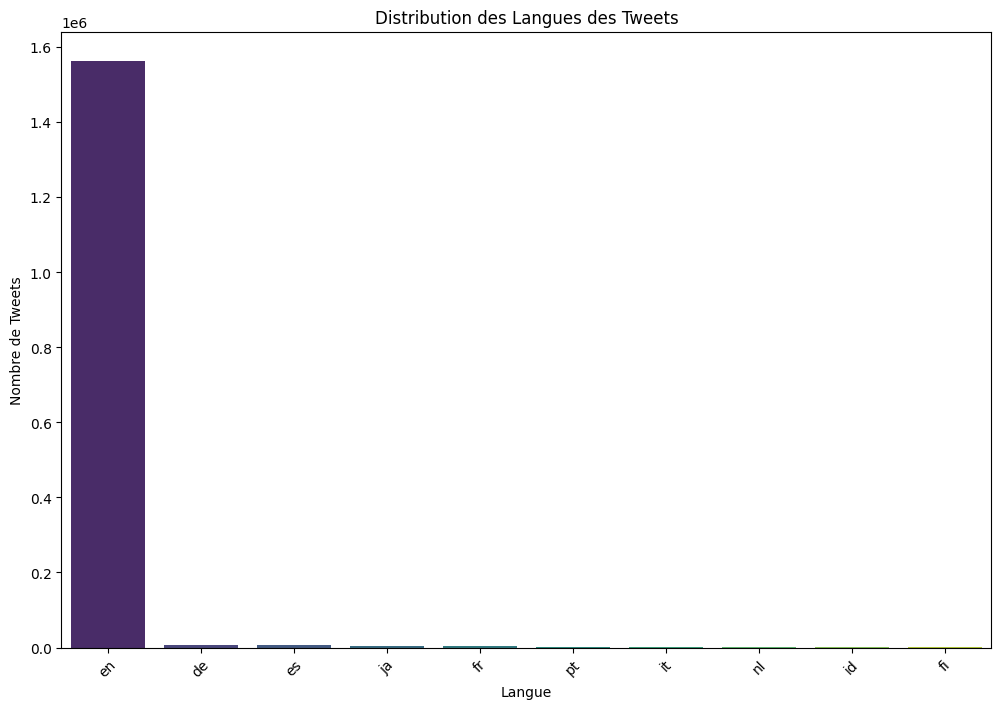

In [18]:
language_distribution = data['language'].value_counts().head(10)
plt.figure(figsize=(12, 8))
sns.barplot(x=language_distribution.index, y=language_distribution.values, palette='viridis')
plt.title('Distribution des Langues des Tweets')
plt.xlabel('Langue')
plt.ylabel('Nombre de Tweets')
plt.xticks(rotation=45)
plt.show()

La langue prédominante est manifestement l'anglais.

## Supprimer toutes les autres langues

In [19]:
data = data[data['language'] == 'en']

/tmp/ipykernel_2490986/861793175.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=language_distribution.index, y=language_distribution.values, palette='viridis')


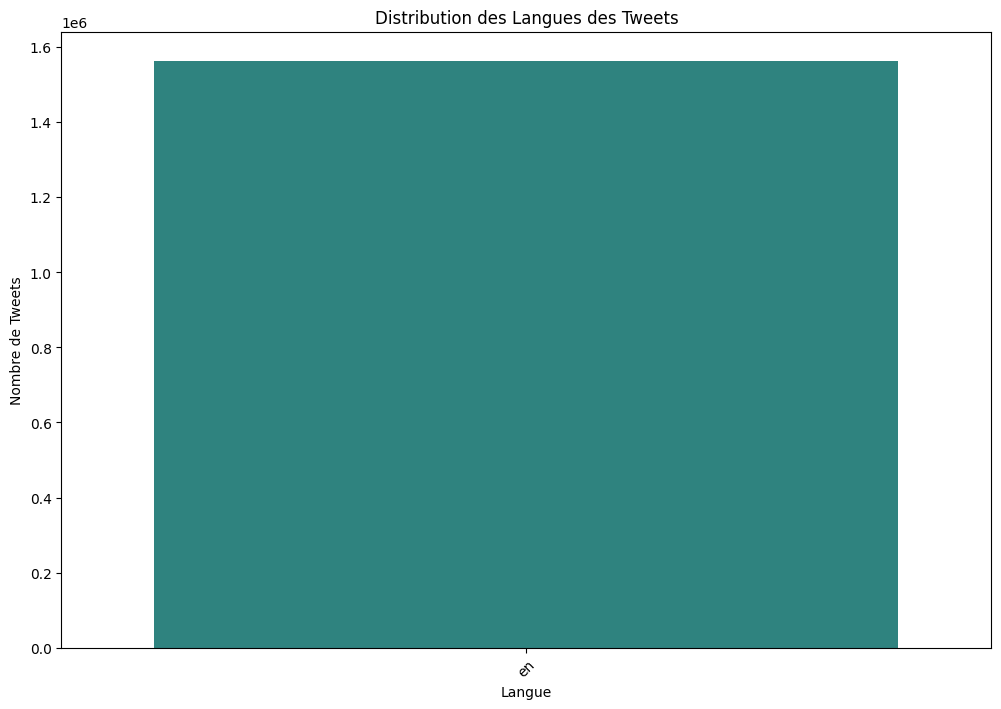

In [20]:
language_distribution = data['language'].value_counts().head(10)
plt.figure(figsize=(12, 8))
sns.barplot(x=language_distribution.index, y=language_distribution.values, palette='viridis')
plt.title('Distribution des Langues des Tweets')
plt.xlabel('Langue')
plt.ylabel('Nombre de Tweets')
plt.xticks(rotation=45)
plt.show()

## Nettoyage des Données

### Nettoyage Textuel
Suppression des URL, mentions, hashtags, ponctuations, et caractères spéciaux.

In [21]:
def clean_text(text):
    text = re.sub(r'http\S+', '[URL]', text)  # Remplacement des URL par [URL]
    text = re.sub(r'@\w+', '[MENTION]', text)  # Remplacement des mentions par [MENTION]
    text = re.sub(r'#\w+', '[HASHTAG]', text)  # Remplacement des hashtags par [HASHTAG]
    # text = re.sub(r'[^\w\s]', '', text)  # Suppression des ponctuations
    # return text.strip().lower()
    return text.strip()

data['cleaned_text'] = data['text'].apply(clean_text)

### Suppression des Duplicatas
TODO supprimer les texte identique de la même personne

In [22]:
display(len(data))

1563214

In [23]:
data = data.drop_duplicates(subset=['user','cleaned_text'])

In [24]:
display(len(data))

1553050

### Sauvegarde des Données Nettoyées

In [26]:
display(data.describe(include='all'))

In [25]:
data = data[['target', 'cleaned_text']]

In [ ]:
display(data.describe(include='all'))

In [26]:
data.to_csv('./data/001/sentiment140_cleaned.csv', index=False)

# Préparation des Données

## Tokenization

In [27]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case = True)
phi3_tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")

/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Comparaison des Approches

In [28]:
sample_text = "Bonjour OpenClassRoom ! comment vas tu ? [URL] [MENTION][HASHTAG]"
print("Original:", sample_text)
print("BERT Tokenized:", bert_tokenizer.tokenize(sample_text))
print("Phi-3 Tokenized:", phi3_tokenizer.tokenize(sample_text))

Original: Bonjour OpenClassRoom ! comment vas tu ? [URL] [MENTION][HASHTAG]
BERT Tokenized: ['bon', '##jou', '##r', 'open', '##class', '##room', '!', 'comment', 'va', '##s', 'tu', '?', '[', 'ur', '##l', ']', '[', 'mention', ']', '[', 'hash', '##tag', ']']
Phi-3 Tokenized: ['▁Bon', 'j', 'our', '▁Open', 'Class', 'Ro', 'om', '▁!', '▁comment', '▁vas', '▁tu', '▁?', '▁[', 'URL', ']', '▁[', 'MENT', 'ION', '][', 'H', 'AS', 'HT', 'AG', ']']


In [29]:
# Ajouter des tokens spéciaux pour les URLs, mentions et hashtags
special_tokens = {
    'additional_special_tokens': ['[URL]', '[MENTION]', '[HASHTAG]']
}

# Ajouter ces tokens spéciaux au tokenizer
bert_tokenizer.add_special_tokens(special_tokens)

3

In [32]:
# Liste des tokens spéciaux
special_tokens = {
    'additional_special_tokens': ['[URL]', '[MENTION]', '[HASHTAG]']
}

# Ajouter ces tokens spéciaux au tokenizer
phi3_tokenizer.add_special_tokens(special_tokens)

# Spécifier un token de padding si non défini dans le tokenizer
phi3_tokenizer.pad_token = phi3_tokenizer.eos_token

In [33]:
sample_text = "Bonjour OpenClassRoom ! comment vas tu ? [URL] [MENTION][HASHTAG]"
print("Original:", sample_text)
print("BERT Tokenized:", bert_tokenizer.tokenize(sample_text))
print("Phi-3 Tokenized:", phi3_tokenizer.tokenize(sample_text))

Original: Bonjour OpenClassRoom ! comment vas tu ? [URL] [MENTION][HASHTAG]
BERT Tokenized: ['bon', '##jou', '##r', 'open', '##class', '##room', '!', 'comment', 'va', '##s', 'tu', '?', '[URL]', '[MENTION]', '[HASHTAG]']
Phi-3 Tokenized: ['▁Bon', 'j', 'our', '▁Open', 'Class', 'Ro', 'om', '▁!', '▁comment', '▁vas', '▁tu', '▁?', '▁', '[URL]', '▁▁', '[MENTION]', '[HASHTAG]']


### Analyse des Tokens

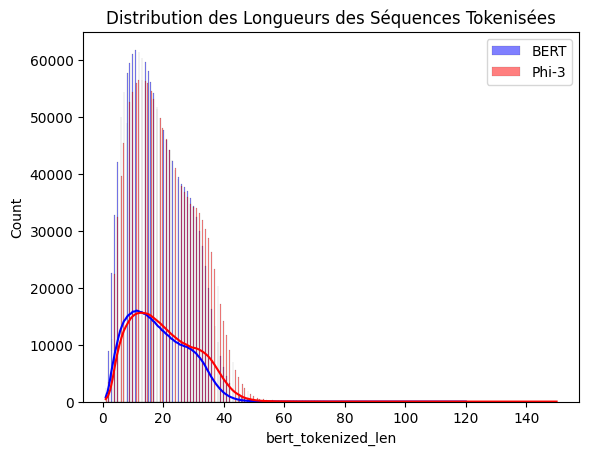

In [34]:
data['bert_tokenized_len'] = data['cleaned_text'].apply(lambda x: len(bert_tokenizer.tokenize(x)))
data['phi3_tokenized_len'] = data['cleaned_text'].apply(lambda x: len(phi3_tokenizer.tokenize(x)))

sns.histplot(data['bert_tokenized_len'], kde=True, color='blue', label='BERT')
sns.histplot(data['phi3_tokenized_len'], kde=True, color='red', label='Phi-3')
plt.legend()
plt.title('Distribution des Longueurs des Séquences Tokenisées')
plt.show()

1. **Différences de Longueur des Séquences** :
   - La distribution des longueurs des séquences pour BERT (en bleu) et Phi-3 (en rouge) montre que les séquences tokenisées par BERT tendent à être légèrement plus longues que celles tokenisées par Phi-3, en particulier dans les premiers intervalles.
   - Cela s'explique par la manière dont chaque modèle effectue la tokenisation. BERT utilise une technique appelée "WordPiece tokenization," qui segmente les mots en sous-mots, ce qui peut parfois entraîner des séquences plus longues, surtout pour les mots peu communs ou les mots composés.

2. **Pic de Distribution** :
   - Les deux distributions montrent un pic autour de 10 à 20 tokens, ce qui suggère que la majorité des tweets, après tokenisation, tombent dans cette plage de longueur pour les deux modèles. Cependant, la distribution de BERT semble avoir un pic légèrement plus marqué, ce qui peut indiquer qu'il génère plus de tokens pour une majorité de tweets.
   - Phi-3, en utilisant une méthode de tokenisation plus proche de BPE (Byte-Pair Encoding), tend à produire des séquences un peu plus courtes pour les mêmes textes.

3. **Longueurs Extrêmes** :
   - Les séquences les plus longues sont plus fréquentes avec BERT, ce qui peut être dû à son approche plus granulaire de la tokenisation. Phi-3, de son côté, produit moins de séquences de longueur extrême.

In [35]:
# Calcul de la longueur maximale des séquences tokenisées pour BERT
max_bert_length = data['bert_tokenized_len'].max()

# Calcul de la longueur maximale des séquences tokenisées pour Phi-3
max_phi3_length = data['phi3_tokenized_len'].max()

# Affichage des résultats
print(f"Longueur maximale d'un tweet tokenisé par BERT : {max_bert_length}")
print(f"Longueur maximale d'un tweet tokenisé par Phi-3 : {max_phi3_length}")

Longueur maximale d'un tweet tokenisé par BERT : 120
Longueur maximale d'un tweet tokenisé par Phi-3 : 150


## Séparation Train/Test

In [2]:
data = pd.read_csv('./data/001/sentiment140_cleaned.csv')

In [ ]:
# class_proportions = data['target'].value_counts(normalize=True)
# n_classes = len(class_proportions)
# n_samples_per_class = 1000 // n_classes 

# sampled_data = data.groupby('target').apply(lambda x: x.sample(n=n_samples_per_class, random_state=42)).reset_index(drop=True)
# data = sampled_data

In [3]:
display(len(data[data['target'] == 0]))
display(len(data[data['target'] == 1]))

782114

770936

In [4]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['cleaned_text'], data['target'], test_size=0.2, random_state=42,stratify=data['target']
)

# Création du Modèle BERT

## Initialisation

In [5]:
# Initialisation du tokenizer BERT avec ajout de tokens spéciaux
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Ajouter des tokens spéciaux pour les URLs, mentions et hashtags
special_tokens = {
    'additional_special_tokens': ['[URL]', '[MENTION]', '[HASHTAG]']
}

# Ajouter ces tokens spéciaux au tokenizer
bert_tokenizer.add_special_tokens(special_tokens)

# Encoder les données d'entraînement
encoder_train = bert_tokenizer.batch_encode_plus(
    train_texts.tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=200,
    return_tensors='pt'
)

# Encoder les données de test
encoder_test = bert_tokenizer.batch_encode_plus(
    test_texts.tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=200,
    return_tensors='pt'
)

/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a futu

In [6]:
# Récupérer les identifiants d'entrée et les masques d'attention pour l'entraînement
input_ids_train = encoder_train['input_ids']
attention_masks_train = encoder_train["attention_mask"]
labels_train = torch.tensor(train_labels.values)

# Récupérer les identifiants d'entrée et les masques d'attention pour le test
input_ids_test = encoder_test['input_ids']
attention_masks_test = encoder_test["attention_mask"]
labels_test = torch.tensor(test_labels.values)

In [7]:
from torch.utils.data import TensorDataset

# Créer des datasets Tensor pour l'entraînement et le test
data_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
data_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

# Afficher la longueur des datasets d'entraînement et de test
len(data_train), len(data_test)

(1242440, 310610)

In [8]:
# Charger le modèle BERT pour la classification des séquences
bert_model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)

# Mettre à jour le modèle pour reconnaître les nouveaux tokens
bert_model.resize_token_embeddings(len(bert_tokenizer))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(30525, 768, padding_idx=0)

## Définition des Arguments d'Entraînement

In [10]:
training_args = TrainingArguments(
    num_train_epochs=3,  # Nombre d'époques d'entraînement
    output_dir='./results',  # Répertoire pour sauvegarder les résultats
    evaluation_strategy="epoch",  # Évaluer le modèle à la fin de chaque époque
    save_strategy="epoch",  # Sauvegarder le modèle à la fin de chaque époque
    learning_rate=2e-5,  # Taux d'apprentissage pour l'optimisation
    per_device_train_batch_size=4,  # Réduire la taille du batch pour s'adapter à 5Go de VRAM
    per_device_eval_batch_size=4,   # Réduire la taille du batch pour s'adapter à 5Go de VRAM
    weight_decay=0.01,  # Décroissance du poids pour la régularisation
    load_best_model_at_end=True,  # Charger le meilleur modèle à la fin de l'entraînement
    metric_for_best_model='eval_loss',  # Utiliser la perte d'évaluation pour déterminer le meilleur modèle
    greater_is_better=False,  # Plus la perte est faible, meilleur est le modèle
    dataloader_num_workers=4,  # Réduire le nombre de workers pour économiser de la RAM
    fp16=True,  # Utiliser la précision mixte pour accélérer l'entraînement et économiser de la VRAM
    gradient_accumulation_steps=4,  # Accumuler les gradients sur plusieurs étapes pour simuler un plus grand batch size
    resume_from_checkpoint=True,  # Reprendre l'entraînement à partir du checkpoint
    save_total_limit=5,  # Limiter le nombre de checkpoints sauvegardés à 1 (le meilleur modèle)

    logging_steps=1000,  # Fréquence d'enregistrement des logs (tous les 10 batches)
    logging_strategy="epoch",  # Enregistrer les logs à chaque époque
)

/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## Entraînement

In [11]:
import torch

class SentimentDataset:
    """
    Classe utilisée pour créer un collateur de batch pour un dataset de sentiments.

    Cette classe prend un tokenizer et une longueur maximale, et permet de formater les batches de données
    sous une forme prête pour l'entraînement.

    Attributs :
    ----------
    tokenizer : objet Tokenizer
        Le tokenizer utilisé pour transformer les textes en tokens.
    max_length : int
        La longueur maximale des séquences de tokens. Toute séquence plus longue sera tronquée.

    Méthodes :
    --------
    __call__(self, batch):
        Prend un batch de données et retourne les `input_ids`, `attention_masks`, et `labels`,
        en les limitant à la longueur maximale définie.
    """
    
    def __init__(self, tokenizer, max_length=200):
        """
        Initialise la classe SentimentDataset.

        Paramètres :
        ----------
        tokenizer : objet Tokenizer
            Le tokenizer utilisé pour transformer les textes en tokens.
        max_length : int, optionnel
            La longueur maximale des séquences de tokens (par défaut 200).
        """
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __call__(self, batch):
        """
        Applique le collateur au batch fourni.

        Paramètres :
        ----------
        batch : liste de tuples
            Chaque élément du batch est un tuple contenant (input_ids, attention_mask, label).

        Retourne :
        --------
        dict :
            Un dictionnaire avec les clés suivantes :
            - 'input_ids' : un tensor PyTorch contenant les `input_ids` des tokens pour chaque élément du batch.
            - 'attention_mask' : un tensor PyTorch contenant les masques d'attention correspondants.
            - 'labels' : un tensor PyTorch des labels associés à chaque entrée du batch.
        """
        # Extraction des input_ids, attention_masks, et labels à partir du batch
        input_ids = torch.stack([item[0] for item in batch])
        attention_masks = torch.stack([item[1] for item in batch])
        labels = torch.stack([item[2] for item in batch])
        
        # Tronquer les séquences à la longueur maximale
        input_ids = input_ids[:, :self.max_length]
        attention_masks = attention_masks[:, :self.max_length]
        
        # Retourne un dictionnaire contenant les données prêtes pour le modèle
        return {
            'input_ids': input_ids,
            'attention_mask': attention_masks,
            'labels': labels
        }

# Création du collateur pour traiter les batches de données sentimentales
sentiment_collator = SentimentDataset(tokenizer=bert_tokenizer, max_length=200)

In [12]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Création d'un callback pour l'arrêt anticipé (early stopping)
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=3  # Nombre d'époques sans amélioration avant d'arrêter l'entraînement
)

def compute_metrics(p):
    """
    Fonction pour calculer les métriques d'évaluation lors de l'entraînement d'un modèle.

    Cette fonction prend les prédictions et les labels réels du batch et calcule les métriques suivantes :
    - Précision
    - Rappel
    - Score F1
    - Exactitude (Accuracy)

    Paramètres :
    ----------
    p : EvalPrediction
        Un objet qui contient les prédictions du modèle ainsi que les labels réels.

    Retourne :
    --------
    dict :
        Un dictionnaire contenant les métriques calculées (accuracy, precision, recall, f1).
    """
    # Obtenir les prédictions les plus probables (classes) à partir des logits
    preds = p.predictions.argmax(-1)
    
    # Calcul des métriques de précision, rappel et F1 pour une classification binaire
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='binary')
    
    # Calcul de l'exactitude (accuracy)
    acc = accuracy_score(p.label_ids, preds)
    
    # Retourner les métriques sous forme de dictionnaire
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# Configuration du formateur (Trainer) pour entraîner et évaluer le modèle
trainer = Trainer(
    model=bert_model,                  # Le modèle BERT que l'on souhaite entraîner
    args=training_args,                # Arguments de configuration de l'entraînement
    train_dataset=data_train,          # Dataset d'entraînement
    eval_dataset=data_test,            # Dataset d'évaluation
    data_collator=sentiment_collator,  # Collateur de données pour préparer les batches
    compute_metrics=compute_metrics,   # Fonction pour calculer les métriques d'évaluation
    callbacks=[early_stopping]         # Callback pour arrêter l'entraînement si les performances cessent de s'améliorer
)


/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [13]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

trainer.train()

[2024-09-16 10:19:18,750] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/usr/bin/ld : ne peut pas trouver -laio : Aucun fichier ou dossier de ce nom
collect2: error: ld returned 1 exit status
/usr/bin/ld : ne peut pas trouver -lcufile : Aucun fichier ou dossier de ce nom
collect2: error: ld returned 1 exit status
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nicolas-poubelle (nicolas-poubelle-olicy). Use `wandb login --relogin` to force relogin


 33%|███▎      | 77652/232956 [4:53:23<10:19:43,  4.18it/s]

{'loss': 0.333, 'grad_norm': 6.324601173400879, 'learning_rate': 1.3335737220762722e-05, 'epoch': 1.0}


                                                           
 33%|███▎      | 77652/232956 [5:12:11<10:19:43,  4.18it/s]

{'eval_loss': 0.30709001421928406, 'eval_accuracy': 0.8686133736840411, 'eval_precision': 0.8953255646910326, 'eval_recall': 0.8326707180242173, 'eval_f1': 0.8628622506586375, 'eval_runtime': 1128.5992, 'eval_samples_per_second': 275.217, 'eval_steps_per_second': 68.805, 'epoch': 1.0}


 67%|██████▋   | 155305/232956 [10:04:35<6:25:07,  3.36it/s]

{'loss': 0.2691, 'grad_norm': 6.060823917388916, 'learning_rate': 6.6715602946479175e-06, 'epoch': 2.0}


                                                            
 67%|██████▋   | 155305/232956 [10:23:17<6:25:07,  3.36it/s]

{'eval_loss': 0.31469303369522095, 'eval_accuracy': 0.8746498824892952, 'eval_precision': 0.8684385509507307, 'eval_recall': 0.880936784553821, 'eval_f1': 0.8746430215748584, 'eval_runtime': 1121.6191, 'eval_samples_per_second': 276.93, 'eval_steps_per_second': 69.233, 'epoch': 2.0}


100%|██████████| 232956/232956 [15:15:33<00:00,  4.11it/s]      

{'loss': 0.2147, 'grad_norm': 1.2867555618286133, 'learning_rate': 7.469221655591614e-09, 'epoch': 3.0}


                                                          
100%|██████████| 232956/232956 [15:34:15<00:00,  4.11it/s]

{'eval_loss': 0.3771897554397583, 'eval_accuracy': 0.8735134090982261, 'eval_precision': 0.8753372838280162, 'eval_recall': 0.8689448526788899, 'eval_f1': 0.8721293547883143, 'eval_runtime': 1121.5261, 'eval_samples_per_second': 276.953, 'eval_steps_per_second': 69.239, 'epoch': 3.0}


100%|██████████| 232956/232956 [15:34:17<00:00,  4.16it/s]

{'train_runtime': 56058.6452, 'train_samples_per_second': 66.49, 'train_steps_per_second': 4.156, 'train_loss': 0.2722710042347053, 'epoch': 3.0}


TrainOutput(global_step=232956, training_loss=0.2722710042347053, metrics={'train_runtime': 56058.6452, 'train_samples_per_second': 66.49, 'train_steps_per_second': 4.156, 'total_flos': 3.83083118827776e+17, 'train_loss': 0.2722710042347053, 'epoch': 2.999980683171823})

## Sauvegarde du Modèle BERT

In [14]:
# Après avoir fini l'entraînement
trainer.save_model('./models/bert_model')

# Sauvegarder l'état du modèle (si nécessaire)
trainer.save_state()

In [6]:
bert_tokenizer.save_pretrained('./models/bert_model')

('./models/bert_model/tokenizer_config.json',
 './models/bert_model/special_tokens_map.json',
 './models/bert_model/vocab.txt',
 './models/bert_model/added_tokens.json')

# Évaluation du Modèle BERT

## Évaluation

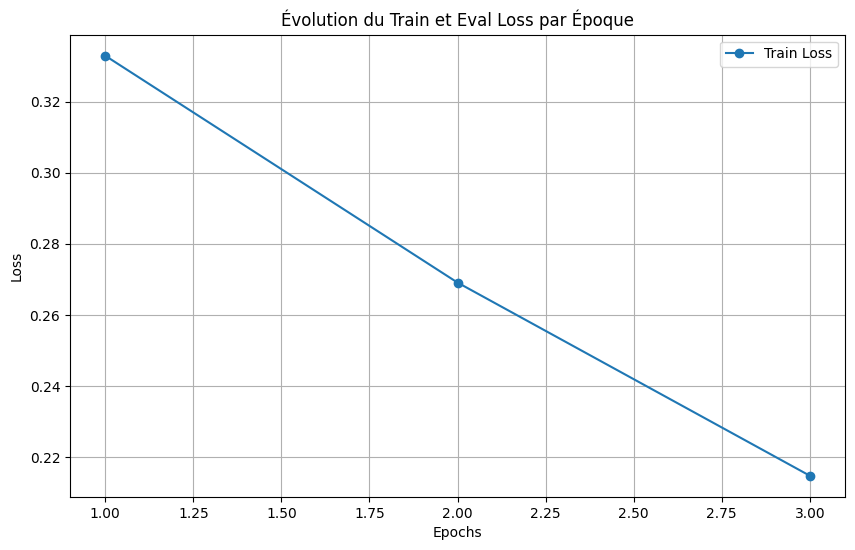

In [19]:
# Récupérer les logs d'entraînement du Trainer
training_logs = trainer.state.log_history

# Créer des listes pour stocker les valeurs de loss et des époques
epochs = []
train_loss = []
eval_loss = []

# Parcourir les logs pour récupérer les valeurs de perte (loss) et d'évaluation
for log in training_logs:
    # Si une époque et une perte d'entraînement sont présentes, on les enregistre
    if 'epoch' in log and 'loss' in log:
        epochs.append(log['epoch'])
        train_loss.append(log['loss'])
    # Si une perte d'évaluation est présente, on l'ajoute à la liste correspondante
    if 'epoch' in log and 'eval_loss' in log:
        eval_loss.append(log['eval_loss'])

# Tracer le graphique de l'évolution du loss
plt.figure(figsize=(10, 6))

# Tracer le loss d'entraînement
plt.plot(epochs, train_loss, label='Train Loss', marker='o')

# Si eval_loss est disponible et a la même longueur que epochs, tracer aussi
if len(eval_loss) == len(epochs):
    plt.plot(epochs, eval_loss, label='Eval Loss', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Évolution du Train et Eval Loss par Époque')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Évaluer le modèle pour obtenir les métriques
eval_results = trainer.evaluate(data_test)
print("Evaluation results:", eval_results)

# Sauvegarder les métriques
trainer.save_metrics('../metrics/bert_model', eval_results)

100%|██████████| 77653/77653 [18:20<00:00, 70.55it/s]

Evaluation results: {'eval_loss': 0.30709001421928406, 'eval_accuracy': 0.8686133736840411, 'eval_precision': 0.8953255646910326, 'eval_recall': 0.8326707180242173, 'eval_f1': 0.8628622506586375, 'eval_runtime': 1101.2428, 'eval_samples_per_second': 282.054, 'eval_steps_per_second': 70.514, 'epoch': 2.999980683171823}


## Calcul des Métriques

In [16]:
metric = load_metric("accuracy")
bert_model.eval()
predictions, label_ids, metrics = trainer.predict(data_test)

/tmp/ipykernel_2491137/3769951972.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
Using the latest cached version of the module from /home/s8n/.cache/huggingface/modules/datasets_modules/metrics/accuracy/9756d5fa4a0f9da966341741fc3926eafdc604b8276add51d5abbaa8958a25f9 (last modified on Fri Aug 30 11:05:30 2024) since it couldn't be found locally at accuracy, or remotely on the Hugging Face Hub.
100%|██████████| 77653/77653 [18:20<00:00, 70.54it/s]


In [17]:
accuracy = metric.compute(predictions=np.argmax(predictions, axis=1), references=label_ids)
print(f"Accuracy of BERT: {accuracy['accuracy']}")

Accuracy of BERT: 0.8686133736840411


### Confusion Matrix

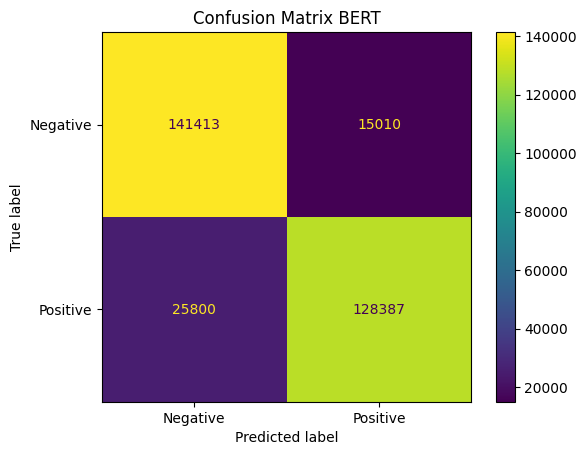

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(label_ids, np.argmax(predictions, axis=1))
ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Positive']).plot()
plt.title('Confusion Matrix BERT')
plt.show()

# Création du Modèle Phi-3

## Initialisation

### Importation des bibliothèques nécessaires
Import des bibliothèques nécessaires pour charger les données, manipuler les modèles, et visualiser les résultats.

In [1]:
import pandas as pd  # Manipulation des dataframes pour gérer les données des tweets
import torch  # Utilisé pour la gestion du modèle et les tenseurs
from transformers import Phi3ForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, BitsAndBytesConfig  # Utilitaires pour le modèle Phi-3
from sklearn.model_selection import train_test_split  # Pour diviser les données en jeu d'entraînement et de test
from peft import LoraConfig, TaskType, get_peft_model  # Pour intégrer LoRA au modèle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # Pour calculer et afficher la matrice de confusion
import matplotlib.pyplot as plt  # Pour afficher les graphiques
import numpy as np  # Manipulation des tableaux de données
from datasets import load_metric  # Chargement des métriques pour évaluer le modèle
import os  # Gestion des fichiers et du système
from huggingface_hub import login  # Pour authentification avec Hugging Face
from tqdm import tqdm  # Barre de progression pour suivre les processus longs

/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Chargement des données de tweets à partir d'un fichier CSV
Ces données sont pré-traitées pour être adaptées à la tâche de classification

In [2]:
# Chargement des données
data = pd.read_csv('./data/001/sentiment140_cleaned.csv')

### Équilibrage des classes (par exemple, même nombre de classes positives et négatives)
On prend un nombre d'exemples égal pour chaque classe afin d'éviter un déséquilibre de classe.

Ce code est utile pendant les phases de test d'entrainement

In [3]:
# # Équilibrage des classes
# class_proportions = data['target'].value_counts(normalize=True)
# n_classes = len(class_proportions)
# n_samples_per_class = 50000 // n_classes
# sampled_data = data.groupby('target').apply(lambda x: x.sample(n=n_samples_per_class, random_state=42)).reset_index(drop=True)
# data = sampled_data

### Séparation du jeu de données en ensembles d'entraînement et de test (80% pour l'entraînement, 20% pour le test)

In [3]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['cleaned_text'], data['target'], test_size=0.2, random_state=42, stratify=data['target']
)

### Authentification Hugging Face avec un token API pour accéder aux modèles hébergés sur Hugging Face

In [4]:
login(token="xxxxxxxxx")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/s8n/.cache/huggingface/token
Login successful


## Configuration du Modèle et Quantification
Nous utilisons le modèle Phi-3 avec une quantification 4-bit pour optimiser la mémoire.

In [5]:
# Configuration de BitsAndBytes pour utiliser une quantification 4-bit (réduction de la mémoire et optimisation)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  # Utilisation de la quantification 4-bit pour économiser de la mémoire
    bnb_4bit_quant_type="nf4",  # Type de quantification utilisé : Normal-Four (nf4)
    bnb_4bit_use_double_quant=True,  # Activation de la double quantification pour plus d'efficacité
    bnb_4bit_compute_dtype=torch.float16  # Type de calcul utilisé pour la quantification
)
# bnb_config = BitsAndBytesConfig(
#     load_in_8bit=True,  # Activer la quantification en 8 bits
#     bnb_8bit_compute_dtype=torch.float16  # Le type de données pour les calculs (ici float16 pour optimiser la mémoire)
# )

# Chargement du modèle Phi3 pour la classification
model_name = "microsoft/Phi-3-mini-4k-instruct"  # Nom du modèle Phi3 sur HuggingFace

# Limitation de la mémoire allouée pour le modèle sur GPU et CPU
max_memory = {
    0: "5GB",  # Limite mémoire GPU
    "cpu": "25GB"  # Limite mémoire CPU
}

# Chargement du modèle Phi-3 avec quantification 4-bit
model = Phi3ForSequenceClassification.from_pretrained(
    model_name,  # Modèle Phi-3 pré-entraîné
    quantization_config=bnb_config,  # Configuration de la quantification 4-bit
    device_map="auto",  # Attribution automatique aux dispositifs (GPU/CPU)
    num_labels=2,  # Deux classes (positif, négatif)
    ignore_mismatched_sizes=True,  # Ignore les erreurs de taille de couches incompatibles
    max_memory=max_memory,  # Limites mémoire pour GPU et CPU
    # offload_folder="offload",  # Dossier pour décharger les données si nécessaire
    # offload_state_dict=True,  # Déchargement des poids pour économiser de la mémoire
    torch_dtype=torch.float16,  # Utilisation de float16 pour économiser de la mémoire
    low_cpu_mem_usage=True  # Réduction de l'utilisation de la mémoire CPU
)

# Chargement du tokenizer associé au modèle Phi3
tokenizer = AutoTokenizer.from_pretrained(model_name)

Loading checkpoint shards: 100%|██████████| 2/2 [00:13<00:00,  6.64s/it]
Some weights of Phi3ForSequenceClassification were not initialized from the model checkpoint at microsoft/Phi-3-mini-4k-instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# Afficher toutes les couches et leur type de précision avant LoRA
print("Avant LoRA :")
for name, param in model.named_parameters():
    print(f"Couche : {name} | Précision : {param.dtype}")

Avant LoRA :
Couche : model.embed_tokens.weight | Précision : torch.float16
Couche : model.layers.0.self_attn.o_proj.weight | Précision : torch.uint8
Couche : model.layers.0.self_attn.qkv_proj.weight | Précision : torch.uint8
Couche : model.layers.0.mlp.gate_up_proj.weight | Précision : torch.uint8
Couche : model.layers.0.mlp.down_proj.weight | Précision : torch.uint8
Couche : model.layers.0.input_layernorm.weight | Précision : torch.float16
Couche : model.layers.0.post_attention_layernorm.weight | Précision : torch.float16
Couche : model.layers.1.self_attn.o_proj.weight | Précision : torch.uint8
Couche : model.layers.1.self_attn.qkv_proj.weight | Précision : torch.uint8
Couche : model.layers.1.mlp.gate_up_proj.weight | Précision : torch.uint8
Couche : model.layers.1.mlp.down_proj.weight | Précision : torch.uint8
Couche : model.layers.1.input_layernorm.weight | Précision : torch.float16
Couche : model.layers.1.post_attention_layernorm.weight | Précision : torch.float16
Couche : model.l

In [7]:
# Afficher la structure du modèle
print(model)

Phi3ForSequenceClassification(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3Attention(
          (o_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear4bit(in_features=3072, out_features=9216, bias=False)
          (rotary_emb): Phi3RotaryEmbedding()
        )
        (mlp): Phi3MLP(
          (gate_up_proj): Linear4bit(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLU()
        )
        (input_layernorm): Phi3RMSNorm((3072,), eps=1e-05)
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
        (post_attention_layernorm): Phi3RMSNorm((3072,), eps=1e-05)
      )
    )
    (norm): Phi3RMS

## Prétraitement des Données : Tokenisation
es textes sont transformés en séquences de tokens utilisables par le modèle.

In [8]:
# Liste des tokens spéciaux
special_tokens = {
    'additional_special_tokens': ['[URL]', '[MENTION]', '[HASHTAG]']
}

# Ajouter ces tokens spéciaux au tokenizer
tokenizer.add_special_tokens(special_tokens)

# Mettre à jour le modèle pour reconnaître ces nouveaux tokens
model.resize_token_embeddings(len(tokenizer))

# Spécifier un token de padding si non défini dans le tokenizer
tokenizer.pad_token = tokenizer.eos_token

# Fonction pour tokeniser les textes par lots
def batch_tokenize(texts, tokenizer, batch_size=10000, max_length=200):
    """
    Tokenisation par lots des textes pour une meilleure gestion de la mémoire.
    
    Args:
        texts (list): Liste des textes à tokeniser.
        tokenizer (AutoTokenizer): Tokenizer associé au modèle.
        batch_size (int): Taille du lot de textes à tokeniser.
        max_length (int): Longueur maximale des séquences après tokenisation.
        
    Returns:
        dict: Contient les tokens 'input_ids' et 'attention_mask'.
    """
    encodings = {'input_ids': [], 'attention_mask': []}  # Initialisation des encodages

    # Tokenisation en lots
    for i in tqdm(range(0, len(texts), batch_size), desc="Tokenisation", unit="batch"):
        batch_texts = texts[i:i+batch_size]  # Sélection d'un lot de textes
        batch_encodings = tokenizer.batch_encode_plus(
            batch_texts,
            padding='max_length',  # Ajout de padding pour les séquences courtes
            truncation=True,  # Tronquer les textes plus longs que la longueur maximale
            max_length=max_length,  # Longueur maximale des séquences
            add_special_tokens=True,  # Ajout des tokens spéciaux pour début et fin de séquence
            return_tensors="pt"  # Retour sous forme de tenseurs PyTorch
        )
        encodings['input_ids'].append(batch_encodings['input_ids'])
        encodings['attention_mask'].append(batch_encodings['attention_mask'])
    
    # Concatenation des encodages pour chaque lot
    encodings['input_ids'] = torch.cat(encodings['input_ids'])
    encodings['attention_mask'] = torch.cat(encodings['attention_mask'])
    
    return encodings

# Tokenisation des textes d'entraînement
train_encodings = batch_tokenize(list(train_texts), tokenizer, batch_size=10000, max_length=200)

# Tokenisation des textes de test
test_encodings = batch_tokenize(list(test_texts), tokenizer, batch_size=10000, max_length=200)

Tokenisation: 100%|██████████| 32/32 [00:22<00:00,  1.43batch/s]


In [9]:
print("Taille du vocabulaire du tokenizer :", len(tokenizer))

Taille du vocabulaire du tokenizer : 32014


## Création du Dataset pour le Modèle
Transformation des données tokenisées en Dataset PyTorch pour l'entraînement et le test.

In [10]:
class SentimentDataset(torch.utils.data.Dataset):
    """
    Classe représentant un Dataset pour l'analyse de sentiment.
    
    Cette classe est utilisée pour créer un Dataset compatible avec PyTorch, où les textes ont été
    tokenisés et chaque texte est associé à une étiquette de sentiment (0 pour négatif, 1 pour positif).
    
    Args:
    -----
        encodings (dict): Dictionnaire contenant les encodages 'input_ids' et 'attention_mask'.
        labels (list): Liste des étiquettes (0 pour négatif, 1 pour positif).
    
    Methods:
    --------
        __getitem__(idx): Retourne un item encodé (séquences tokenisées) et son label associé.
        __len__(): Retourne la taille du dataset, c'est-à-dire le nombre total d'éléments.
    """
    
    def __init__(self, encodings, labels):
        """
        Initialise le Dataset avec les encodages et les étiquettes de sentiment.
        
        Args:
        -----
            encodings (dict): Dictionnaire contenant les encodages tokenisés ('input_ids', 'attention_mask').
            labels (list): Liste des étiquettes (0 pour négatif, 1 pour positif).
        """
        # Initialisation des encodages des textes et des labels associés
        self.encodings = encodings  # Textes tokenisés sous forme de dictionnaire
        self.labels = labels  # Liste des étiquettes de sentiment

    def __getitem__(self, idx):
        """
        Retourne un élément du dataset à l'index donné, incluant les encodages et le label.
        
        Args:
        -----
            idx (int): Index de l'élément à retourner.
        
        Returns:
        --------
            dict: Un dictionnaire contenant les encodages ('input_ids', 'attention_mask') et le label correspondant.
        """
        # Création d'un item en clonant et détachant les tenseurs pour éviter des modifications non désirées
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        # Ajout de l'étiquette (label) comme un tenseur
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Retourne la taille du dataset, c'est-à-dire le nombre total d'éléments dans celui-ci.
        
        Returns:
        --------
            int: Le nombre total d'échantillons (éléments) dans le dataset.
        """
        # Retourne le nombre d'étiquettes, ce qui correspond à la taille du dataset
        return len(self.labels)

# Création des datasets pour l'entraînement et le test à partir des encodages et des labels
train_dataset = SentimentDataset(train_encodings, list(train_labels))
test_dataset = SentimentDataset(test_encodings, list(test_labels))

## Application de LoRA pour l'Adaptation Fine-Tuning
LoRA (Low-Rank Adaptation) est utilisé pour appliquer des modifications spécifiques aux couches du modèle, ce qui permet un fine-tuning plus rapide et plus efficace avec une consommation de mémoire réduite.


In [11]:
# Inspection des modules du modèle Phi-3
for name, module in model.named_modules():
    print(name)


model
model.embed_tokens
model.embed_dropout
model.layers
model.layers.0
model.layers.0.self_attn
model.layers.0.self_attn.o_proj
model.layers.0.self_attn.qkv_proj
model.layers.0.self_attn.rotary_emb
model.layers.0.mlp
model.layers.0.mlp.gate_up_proj
model.layers.0.mlp.down_proj
model.layers.0.mlp.activation_fn
model.layers.0.input_layernorm
model.layers.0.resid_attn_dropout
model.layers.0.resid_mlp_dropout
model.layers.0.post_attention_layernorm
model.layers.1
model.layers.1.self_attn
model.layers.1.self_attn.o_proj
model.layers.1.self_attn.qkv_proj
model.layers.1.self_attn.rotary_emb
model.layers.1.mlp
model.layers.1.mlp.gate_up_proj
model.layers.1.mlp.down_proj
model.layers.1.mlp.activation_fn
model.layers.1.input_layernorm
model.layers.1.resid_attn_dropout
model.layers.1.resid_mlp_dropout
model.layers.1.post_attention_layernorm
model.layers.2
model.layers.2.self_attn
model.layers.2.self_attn.o_proj
model.layers.2.self_attn.qkv_proj
model.layers.2.self_attn.rotary_emb
model.layers.

In [12]:
# Définition des modules du modèle sur lesquels appliquer LoRA
# Option 1 : Si seulement le ciblage des blocs d'attention du modèle
target_modules_attention = [
    "layers.0.self_attn.qkv_proj",
    "layers.0.self_attn.o_proj",
    "layers.1.self_attn.qkv_proj",
    "layers.1.self_attn.o_proj",
    "layers.2.self_attn.qkv_proj",
    "layers.2.self_attn.o_proj",
    "layers.3.self_attn.qkv_proj",
    "layers.3.self_attn.o_proj",
    "layers.4.self_attn.qkv_proj",
    "layers.4.self_attn.o_proj",
    "layers.5.self_attn.qkv_proj",
    "layers.5.self_attn.o_proj",
    "layers.6.self_attn.qkv_proj",
    "layers.6.self_attn.o_proj",
    "layers.7.self_attn.qkv_proj",
    "layers.7.self_attn.o_proj",
    "layers.8.self_attn.qkv_proj",
    "layers.8.self_attn.o_proj",
    "layers.9.self_attn.qkv_proj",
    "layers.9.self_attn.o_proj",
    "layers.10.self_attn.qkv_proj",
    "layers.10.self_attn.o_proj",
    "layers.11.self_attn.qkv_proj",
    "layers.11.self_attn.o_proj",
    "layers.12.self_attn.qkv_proj",
    "layers.12.self_attn.o_proj",
    "layers.13.self_attn.qkv_proj",
    "layers.13.self_attn.o_proj",
    "layers.14.self_attn.qkv_proj",
    "layers.14.self_attn.o_proj",
    "layers.15.self_attn.qkv_proj",
    "layers.15.self_attn.o_proj",
    "layers.16.self_attn.qkv_proj",
    "layers.16.self_attn.o_proj",
    "layers.17.self_attn.qkv_proj",
    "layers.17.self_attn.o_proj",
    "layers.18.self_attn.qkv_proj",
    "layers.18.self_attn.o_proj",
    "layers.19.self_attn.qkv_proj",
    "layers.19.self_attn.o_proj",
    "layers.20.self_attn.qkv_proj",
    "layers.20.self_attn.o_proj",
    "layers.21.self_attn.qkv_proj",
    "layers.21.self_attn.o_proj",
    "layers.22.self_attn.qkv_proj",
    "layers.22.self_attn.o_proj",
    "layers.23.self_attn.qkv_proj",
    "layers.23.self_attn.o_proj",
    "layers.24.self_attn.qkv_proj",
    "layers.24.self_attn.o_proj",
    "layers.25.self_attn.qkv_proj",
    "layers.25.self_attn.o_proj",
    "layers.26.self_attn.qkv_proj",
    "layers.26.self_attn.o_proj",
    "layers.27.self_attn.qkv_proj",
    "layers.27.self_attn.o_proj",
    "layers.28.self_attn.qkv_proj",
    "layers.28.self_attn.o_proj",
    "layers.29.self_attn.qkv_proj",
    "layers.29.self_attn.o_proj",
    "layers.30.self_attn.qkv_proj",
    "layers.30.self_attn.o_proj",
    "layers.31.self_attn.qkv_proj",
    "layers.31.self_attn.o_proj"
]

# Option 2 : Si l'on vise toutes les couches linéaires
target_modules_linear = [
    "layers.0.self_attn.qkv_proj",
    "layers.0.self_attn.o_proj",
    "layers.0.mlp.gate_up_proj",
    "layers.0.mlp.down_proj",
    "layers.1.self_attn.qkv_proj",
    "layers.1.self_attn.o_proj",
    "layers.1.mlp.gate_up_proj",
    "layers.1.mlp.down_proj",
    "layers.2.self_attn.qkv_proj",
    "layers.2.self_attn.o_proj",
    "layers.2.mlp.gate_up_proj",
    "layers.2.mlp.down_proj",
    "layers.3.self_attn.qkv_proj",
    "layers.3.self_attn.o_proj",
    "layers.3.mlp.gate_up_proj",
    "layers.3.mlp.down_proj",
    "layers.4.self_attn.qkv_proj",
    "layers.4.self_attn.o_proj",
    "layers.4.mlp.gate_up_proj",
    "layers.4.mlp.down_proj",
    "layers.5.self_attn.qkv_proj",
    "layers.5.self_attn.o_proj",
    "layers.5.mlp.gate_up_proj",
    "layers.5.mlp.down_proj",
    "layers.6.self_attn.qkv_proj",
    "layers.6.self_attn.o_proj",
    "layers.6.mlp.gate_up_proj",
    "layers.6.mlp.down_proj",
    "layers.7.self_attn.qkv_proj",
    "layers.7.self_attn.o_proj",
    "layers.7.mlp.gate_up_proj",
    "layers.7.mlp.down_proj",
    "layers.8.self_attn.qkv_proj",
    "layers.8.self_attn.o_proj",
    "layers.8.mlp.gate_up_proj",
    "layers.8.mlp.down_proj",
    "layers.9.self_attn.qkv_proj",
    "layers.9.self_attn.o_proj",
    "layers.9.mlp.gate_up_proj",
    "layers.9.mlp.down_proj",
    "layers.10.self_attn.qkv_proj",
    "layers.10.self_attn.o_proj",
    "layers.10.mlp.gate_up_proj",
    "layers.10.mlp.down_proj",
    "layers.11.self_attn.qkv_proj",
    "layers.11.self_attn.o_proj",
    "layers.11.mlp.gate_up_proj",
    "layers.11.mlp.down_proj",
    "layers.12.self_attn.qkv_proj",
    "layers.12.self_attn.o_proj",
    "layers.12.mlp.gate_up_proj",
    "layers.12.mlp.down_proj",
    "layers.13.self_attn.qkv_proj",
    "layers.13.self_attn.o_proj",
    "layers.13.mlp.gate_up_proj",
    "layers.13.mlp.down_proj",
    "layers.14.self_attn.qkv_proj",
    "layers.14.self_attn.o_proj",
    "layers.14.mlp.gate_up_proj",
    "layers.14.mlp.down_proj",
    "layers.15.self_attn.qkv_proj",
    "layers.15.self_attn.o_proj",
    "layers.15.mlp.gate_up_proj",
    "layers.15.mlp.down_proj",
    "layers.16.self_attn.qkv_proj",
    "layers.16.self_attn.o_proj",
    "layers.16.mlp.gate_up_proj",
    "layers.16.mlp.down_proj",
    "layers.17.self_attn.qkv_proj",
    "layers.17.self_attn.o_proj",
    "layers.17.mlp.gate_up_proj",
    "layers.17.mlp.down_proj",
    "layers.18.self_attn.qkv_proj",
    "layers.18.self_attn.o_proj",
    "layers.18.mlp.gate_up_proj",
    "layers.18.mlp.down_proj",
    "layers.19.self_attn.qkv_proj",
    "layers.19.self_attn.o_proj",
    "layers.19.mlp.gate_up_proj",
    "layers.19.mlp.down_proj",
    "layers.20.self_attn.qkv_proj",
    "layers.20.self_attn.o_proj",
    "layers.20.mlp.gate_up_proj",
    "layers.20.mlp.down_proj",
    "layers.21.self_attn.qkv_proj",
    "layers.21.self_attn.o_proj",
    "layers.21.mlp.gate_up_proj",
    "layers.21.mlp.down_proj",
    "layers.22.self_attn.qkv_proj",
    "layers.22.self_attn.o_proj",
    "layers.22.mlp.gate_up_proj",
    "layers.22.mlp.down_proj",
    "layers.23.self_attn.qkv_proj",
    "layers.23.self_attn.o_proj",
    "layers.23.mlp.gate_up_proj",
    "layers.23.mlp.down_proj",
    "layers.24.self_attn.qkv_proj",
    "layers.24.self_attn.o_proj",
    "layers.24.mlp.gate_up_proj",
    "layers.24.mlp.down_proj",
    "layers.25.self_attn.qkv_proj",
    "layers.25.self_attn.o_proj",
    "layers.25.mlp.gate_up_proj",
    "layers.25.mlp.down_proj",
    "layers.26.self_attn.qkv_proj",
    "layers.26.self_attn.o_proj",
    "layers.26.mlp.gate_up_proj",
    "layers.26.mlp.down_proj",
    "layers.27.self_attn.qkv_proj",
    "layers.27.self_attn.o_proj",
    "layers.27.mlp.gate_up_proj",
    "layers.27.mlp.down_proj",
    "layers.28.self_attn.qkv_proj",
    "layers.28.self_attn.o_proj",
    "layers.28.mlp.gate_up_proj",
    "layers.28.mlp.down_proj",
    "layers.29.self_attn.qkv_proj",
    "layers.29.self_attn.o_proj",
    "layers.29.mlp.gate_up_proj",
    "layers.29.mlp.down_proj",
    "layers.30.self_attn.qkv_proj",
    "layers.30.self_attn.o_proj",
    "layers.30.mlp.gate_up_proj",
    "layers.30.mlp.down_proj",
    "layers.31.self_attn.qkv_proj",
    "layers.31.self_attn.o_proj",
    "layers.31.mlp.gate_up_proj",
    "layers.31.mlp.down_proj"
]

# Sélection des modules cibles (attention ou linéaires selon l'objectif)
target_modules = target_modules_attention 
# target_modules = target_modules_linear 

In [13]:
# Configuration de LoRA avec des paramètres spécifiques pour l'adaptation du modèle
lora_config = LoraConfig(
    r=16,  # Taille du rang de la décomposition LoRA (16)
    lora_alpha=32,  # Facteur d'échelle pour LoRA
    lora_dropout=0.05,  # Taux de dropout appliqué aux poids LoRA pour éviter l'overfitting
    task_type=TaskType.SEQ_CLS,  # Type de tâche : classification de séquence
    inference_mode=False,  # Indique que LoRA est utilisé pour l'entraînement (non pour l'inférence)
    bias="none",  # Pas de biais ajouté
    target_modules=target_modules,  # Couches cibles où appliquer LoRA
)

# Application de LoRA au modèle Phi3 chargé précédemment
model = get_peft_model(model, lora_config)

# Activation du gradient checkpointing pour réduire l'empreinte mémoire pendant l'entraînement
model.gradient_checkpointing_enable()

In [14]:
# Affichage des paramètres entraînables dans le modèle après application de LoRA
model.print_trainable_parameters()

trainable params: 9,443,328 || all params: 3,731,874,816 || trainable%: 0.2530


In [15]:
# Afficher les couches et leur type de précision après application de LoRA
print("\nAprès LoRA :")
for name, param in model.named_parameters():
    if "lora" in name:
        print(f"Couche LoRA : {name} | Précision : {param.dtype}")
    else:
        print(f"Couche : {name} | Précision : {param.dtype}")


Après LoRA :
Couche : base_model.model.model.embed_tokens.weight | Précision : torch.float16
Couche : base_model.model.model.layers.0.self_attn.o_proj.base_layer.weight | Précision : torch.uint8
Couche LoRA : base_model.model.model.layers.0.self_attn.o_proj.lora_A.default.weight | Précision : torch.float32
Couche LoRA : base_model.model.model.layers.0.self_attn.o_proj.lora_B.default.weight | Précision : torch.float32
Couche : base_model.model.model.layers.0.self_attn.qkv_proj.base_layer.weight | Précision : torch.uint8
Couche LoRA : base_model.model.model.layers.0.self_attn.qkv_proj.lora_A.default.weight | Précision : torch.float32
Couche LoRA : base_model.model.model.layers.0.self_attn.qkv_proj.lora_B.default.weight | Précision : torch.float32
Couche : base_model.model.model.layers.0.mlp.gate_up_proj.weight | Précision : torch.uint8
Couche : base_model.model.model.layers.0.mlp.down_proj.weight | Précision : torch.uint8
Couche : base_model.model.model.layers.0.input_layernorm.weight |

In [16]:
# Afficher la structure du modèle
print(model)

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): Phi3ForSequenceClassification(
      (model): Phi3Model(
        (embed_tokens): Embedding(32014, 3072, padding_idx=32000)
        (embed_dropout): Dropout(p=0.0, inplace=False)
        (layers): ModuleList(
          (0-31): 32 x Phi3DecoderLayer(
            (self_attn): Phi3Attention(
              (o_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=3072, out_features=3072, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3072, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=3072, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()


## Définition des Arguments d'Entraînement

In [17]:
from datetime import datetime
# Génère un horodatage unique pour chaque entraînement
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")

# Ajouter cet horodatage au répertoire de logs
logging_dir = f"./logs/tensorboard_{current_time}"

# Configuration des arguments d'entraînement pour le Trainer de Hugging Face
training_args = TrainingArguments(
    num_train_epochs=3,  # Nombre d'époques pour l'entraînement
    output_dir='./results',  # Répertoire pour sauvegarder les résultats du modèle
    learning_rate=2e-5,  # Taux d'apprentissage utilisé par l'optimiseur
    per_device_train_batch_size=32,  # Taille du batch pour l'entraînement
    per_device_eval_batch_size=4,  # Taille du batch pour l'évaluation
    gradient_accumulation_steps=32,  # Accumulation des gradients sur 32 étapes avant de faire une mise à jour des poids
    optim="paged_adamw_32bit",  # Optimiseur AdamW utilisant des poids en 32-bit ('adamw_hf', 'adamw_torch', 'adamw_torch_fused', 'adamw_torch_xla', 'adamw_torch_npu_fused', 'adamw_apex_fused', 'adafactor', 'adamw_anyprecision', 'sgd', 'adagrad', 'adamw_bnb_8bit', 'adamw_8bit', 'lion_8bit', 'lion_32bit', 'paged_adamw_32bit', 'paged_adamw_8bit', 'paged_lion_32bit', 'paged_lion_8bit', 'rmsprop', 'rmsprop_bnb', 'rmsprop_bnb_8bit', 'rmsprop_bnb_32bit', 'galore_adamw', 'galore_adamw_8bit', 'galore_adafactor', 'galore_adamw_layerwise', 'galore_adamw_8bit_layerwise', 'galore_adafactor_layerwise', 'lomo', 'adalomo')
    weight_decay=0.01,  # Taux de décroissance de poids pour éviter le surapprentissage
    logging_steps=1000,  # Fréquence d'enregistrement des logs (tous les 10 batches)
    logging_strategy="epoch",  # Enregistrer les logs à chaque époque
    evaluation_strategy="epoch",  # Effectuer une évaluation à chaque époque
    save_strategy="epoch",
    load_best_model_at_end=True,  # Charger le meilleur modèle à la fin de l'entraînement
    metric_for_best_model='eval_loss',  # Critère pour définir le meilleur modèle
    greater_is_better=False,  # Indique si une plus grande valeur de la métrique est meilleure (ici non)
    dataloader_num_workers=10,  # Nombre de workers pour charger les données

    report_to="tensorboard",  # Activer TensorBoard pour le suivi
    logging_dir=logging_dir,  # Répertoire pour les fichiers de logs (tensorboard --logdir=./logs)

    # Ajout des options pour le scheduler
    lr_scheduler_type='cosine_with_restarts',  # Type de scheduler ('cosine', 'constant','linear','cosine_with_restarts')
    warmup_steps=1000  # Nombre d'étapes de warm-up pour stabiliser l'apprentissage au début de l'entraînement
)

/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## Entraînement du Modèle

In [18]:
# Initialisation du Trainer de Hugging Face avec les arguments et les datasets
trainer = Trainer(
    model=model,  # Modèle Phi3 avec LoRA
    args=training_args,  # Arguments d'entraînement
    train_dataset=train_dataset,  # Dataset d'entraînement
    eval_dataset=test_dataset,  # Dataset de test
    tokenizer=tokenizer,  # Tokenizer utilisé pour l'encodage des textes
)

In [19]:
# Désactiver la parallélisation de tokenisation pour éviter les erreurs sur certaines configurations
os.environ["TOKENIZERS_PARALLELISM"] = "false"

### Libération de la mémoire CUDA
Je libère la mémoire GPU avant de lancer l'entraînement pour éviter toute erreur liée à la saturation de la mémoire.

In [20]:
# Libération de la mémoire avec les fonctions garbage collector et vidage de cache CUDA
import gc  # Garbage collector pour libérer la mémoire
gc.collect()  # Libérer la mémoire Python
torch.cuda.empty_cache()  # Vider la mémoire CUDA

In [21]:
# Entraînement du modèle
trainer.train()

[2024-09-09 10:13:00,410] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/usr/bin/ld : ne peut pas trouver -laio : Aucun fichier ou dossier de ce nom
collect2: error: ld returned 1 exit status
/usr/bin/ld : ne peut pas trouver -lcufile : Aucun fichier ou dossier de ce nom
collect2: error: ld returned 1 exit status
  0%|          | 0/3639 [00:00<?, ?it/s]`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
You are not running the flash-attention implementation, expect numerical differences.
 33%|███▎      | 1213/3639 [29:44:15<60:41:31, 90.06s/it]

{'loss': 0.6813, 'grad_norm': 3.328125, 'learning_rate': 1.9680241573182663e-05, 'epoch': 1.0}


We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)
                                                         
 33%|███▎      | 1213/3639 [39:09:07<60:41:31, 90.06s/it]/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/peft/utils/other.py:619: UserWarning: Unable to fetch remote file due to the following error (MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /microsoft/Phi-3-mini-4k-instruct/resolve/main/config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7d37804e4640>: Failed to resolve \'huggingface.co\' ([Errno -3] Temporary failure in name resolution)"))'), '(Request ID: d3268278-5148-436d-bc38-0c16befbe69b)') - silently ignoring the lookup for the file config.json in micro

{'eval_loss': 0.5009765625, 'eval_runtime': 33891.5831, 'eval_samples_per_second': 9.165, 'eval_steps_per_second': 2.291, 'epoch': 1.0}


/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
 67%|██████▋   | 2426/3639 [69:31:41<30:15:12, 89.79s/it]     

{'loss': 0.4702, 'grad_norm': 1.62109375, 'learning_rate': 8.7355664769998e-06, 'epoch': 2.0}


                                                         
 67%|██████▋   | 2426/3639 [78:54:29<30:15:12, 89.79s/it]/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/peft/utils/other.py:619: UserWarning: Unable to fetch remote file due to the following error (MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /microsoft/Phi-3-mini-4k-instruct/resolve/main/config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7d38c98c1960>: Failed to resolve \'huggingface.co\' ([Errno -3] Temporary failure in name resolution)"))'), '(Request ID: c4152140-e2ea-4afc-bf34-b3b0301304a5)') - silently ignoring the lookup for the file config.json in microsoft/Phi-3-mini-4k-instruct.
  warnings.warn(
/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:218: UserWarning: Could not find a config file in microsoft/Phi-3-mini-4k-instruct - will assume that the voca

{'eval_loss': 0.456787109375, 'eval_runtime': 33767.6285, 'eval_samples_per_second': 9.198, 'eval_steps_per_second': 2.3, 'epoch': 2.0}


/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 3639/3639 [108:04:02<00:00, 85.03s/it]       /media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:232: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
100%|██████████| 3639/3639 [108:04:03<00:00, 85.03s/it]

{'loss': 0.4533, 'grad_norm': 1.23828125, 'learning_rate': 0.0, 'epoch': 3.0}


                                                       
100%|██████████| 3639/3639 [116:54:07<00:00, 85.03s/it]

{'eval_loss': 0.454345703125, 'eval_runtime': 31804.1249, 'eval_samples_per_second': 9.766, 'eval_steps_per_second': 2.442, 'epoch': 3.0}


/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:232: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
100%|██████████| 3639/3639 [116:54:08<00:00, 115.65s/it]

{'train_runtime': 420848.0937, 'train_samples_per_second': 8.857, 'train_steps_per_second': 0.009, 'train_loss': 0.5349529336592299, 'epoch': 3.0}


TrainOutput(global_step=3639, training_loss=0.5349529336592299, metrics={'train_runtime': 420848.0937, 'train_samples_per_second': 8.857, 'train_steps_per_second': 0.009, 'total_flos': 1.6247485282340045e+19, 'train_loss': 0.5349529336592299, 'epoch': 2.9991500759780565})

## Sauvegarde du Modèle Fine-tuné

In [22]:
# Sauvegarde du LoRA et de son état pour une utilisation ultérieure
trainer.save_model('./models/phi3_model')  # Sauvegarde du LoRA
trainer.save_state()  # Sauvegarde de l'état de l'entraînement

/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:232: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


In [21]:
tokenizer.save_pretrained('./models/phi3_model')

('./models/phi3_model/tokenizer_config.json',
 './models/phi3_model/special_tokens_map.json',
 './models/phi3_model/tokenizer.model',
 './models/phi3_model/added_tokens.json',
 './models/phi3_model/tokenizer.json')

# Évaluation du Modèle Phi-3

## Visualisation de l'évolution du Loss pendant l'entraînement

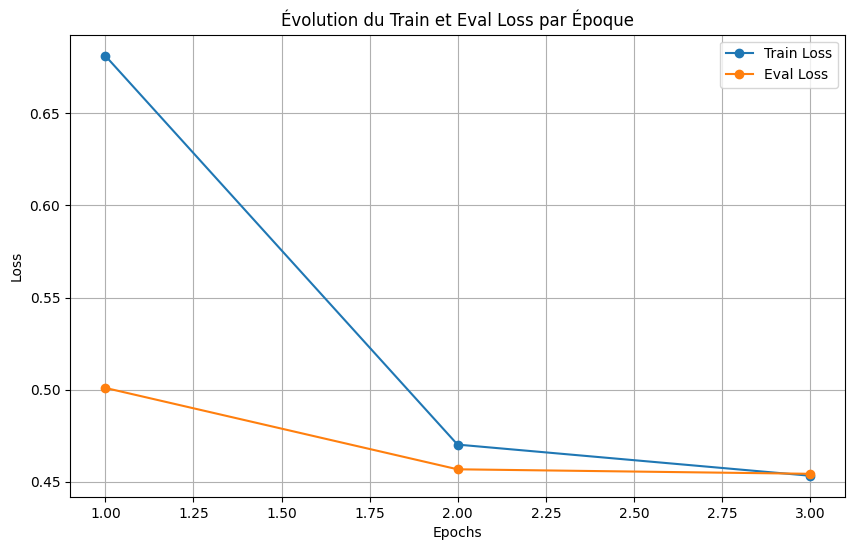

In [23]:
# Récupérer les logs d'entraînement du Trainer
training_logs = trainer.state.log_history

# Créer des listes pour stocker les valeurs de loss et des époques
epochs = []
train_loss = []
eval_loss = []

# Parcourir les logs pour récupérer les valeurs de perte (loss) et d'évaluation
for log in training_logs:
    # Si une époque et une perte d'entraînement sont présentes, on les enregistre
    if 'epoch' in log and 'loss' in log:
        epochs.append(log['epoch'])
        train_loss.append(log['loss'])
    # Si une perte d'évaluation est présente, on l'ajoute à la liste correspondante
    if 'epoch' in log and 'eval_loss' in log:
        eval_loss.append(log['eval_loss'])

# Tracer le graphique de l'évolution du loss
plt.figure(figsize=(10, 6))

# Tracer le loss d'entraînement
plt.plot(epochs, train_loss, label='Train Loss', marker='o')

# Si eval_loss est disponible et a la même longueur que epochs, tracer aussi
if len(eval_loss) == len(epochs):
    plt.plot(epochs, eval_loss, label='Eval Loss', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Évolution du Train et Eval Loss par Époque')
plt.legend()
plt.grid(True)
plt.show()

## Évaluation sur le Jeu de Test

In [24]:
# Évaluation du modèle sur l'ensemble de test
eval_results = trainer.evaluate(test_dataset)

# Affichage des résultats de l'évaluation
print("Résultats de l'évaluation :", eval_results)

100%|██████████| 77653/77653 [8:49:36<00:00,  2.44it/s]  

Résultats de l'évaluation : {'eval_loss': 0.454345703125, 'eval_runtime': 31778.3375, 'eval_samples_per_second': 9.774, 'eval_steps_per_second': 2.444, 'epoch': 2.9991500759780565}


## Calcul et Affichage des Métriques

In [25]:
# Sauvegarde des métriques d'évaluation dans un fichier
trainer.save_metrics('../metrics/phi3_model', eval_results)

# Chargement de la métrique d'accuracy
metric = load_metric("accuracy")

# Passage en mode évaluation du modèle
model.eval()

# Prédictions sur le dataset de test
predictions, label_ids, metrics = trainer.predict(test_dataset)

# Calcul de l'accuracy
accuracy = metric.compute(predictions=np.argmax(predictions, axis=1), references=label_ids)

# Affichage du résultat d'accuracy
print(f"Accuracy du modèle Phi-3: {accuracy['accuracy']}")

/tmp/ipykernel_17281/3111072674.py:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
100%|██████████| 77653/77653 [8:51:12<00:00,  2.44it/s]  


Accuracy du modèle Phi-3: 0.7872154792183124


In [26]:
metric = load_metric("f1")
f1 = metric.compute(predictions=np.argmax(predictions, axis=1), references=label_ids, average="weighted")
print(f"F1-score du modèle Phi-3: {f1['f1']}")

F1-score du modèle Phi-3: 0.787173509794734


## Matrice de Confusion

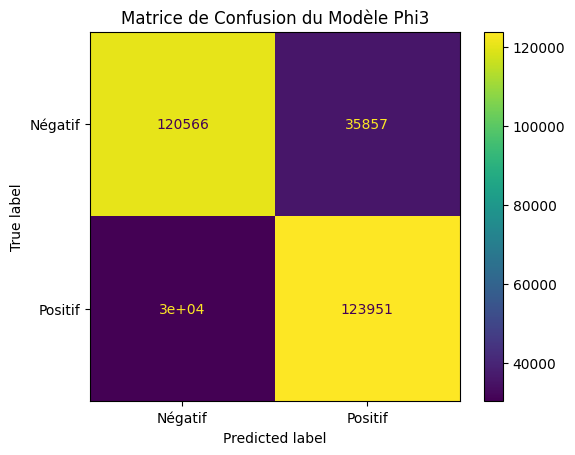

In [27]:
# Calcul de la matrice de confusion entre les prédictions et les labels réels
cm = confusion_matrix(label_ids, np.argmax(predictions, axis=1))

# Affichage de la matrice de confusion sous forme de graphique
ConfusionMatrixDisplay(cm, display_labels=['Négatif', 'Positif']).plot()
plt.title('Matrice de Confusion du Modèle Phi3')
plt.show()

# Fusion de Modèle Phi-3 Pré-entrainé et LoRA pour Sauvegarde Standalone

L'objectif est de combiner le modèle de base Phi-3 avec les ajustements effectués par LoRA afin de sauvegarder le modèle complet en tant que modèle standalone, prêt pour une utilisation future sans dépendre de LoRA séparément.

In [2]:
import torch
from transformers import AutoTokenizer,BitsAndBytesConfig,Phi3ForSequenceClassification
from peft import PeftModel, PeftConfig

# Chemin vers le modèle complet sauvegardé
model_path = './models/phi3_model'

# Charger le tokenizer et le modèle complet
tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.pad_token = tokenizer.eos_token

# Chemin vers le répertoire de l'adapter sauvegardé
peft_model_id = './models/phi3_model'

# Charger la configuration de l'adapter pour obtenir le nom du modèle de base
config = PeftConfig.from_pretrained(peft_model_id)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  # Utilisation de la quantification 4-bit pour économiser de la mémoire
    bnb_4bit_quant_type="nf4",  # Type de quantification utilisé : Normal-Four (nf4)
    bnb_4bit_use_double_quant=True,  # Activation de la double quantification pour plus d'efficacité
    bnb_4bit_compute_dtype=torch.float16  # Type de calcul utilisé pour la quantification
)

# Limitation de la mémoire allouée pour le modèle sur GPU et CPU
max_memory = {
    0: "5GB",  # Limite mémoire GPU
    "cpu": "25GB"  # Limite mémoire CPU
}

# Chargement du modèle Phi-3 avec quantification 4-bit
model = Phi3ForSequenceClassification.from_pretrained(
    config.base_model_name_or_path,
    quantization_config=bnb_config,  # Configuration de la quantification 4-bit
    device_map="auto",  # Attribution automatique aux dispositifs (GPU/CPU)
    num_labels=2,  # Deux classes (positif, négatif)
    ignore_mismatched_sizes=True,  # Ignore les erreurs de taille de couches incompatibles
    max_memory=max_memory,  # Limites mémoire pour GPU et CPU
    torch_dtype=torch.float16,  # Utilisation de float16 pour économiser de la mémoire
    low_cpu_mem_usage=True  # Réduction de l'utilisation de la mémoire CPU
)

# Redimensionner les embeddings du modèle pour correspondre au vocabulaire du tokenizer
model.resize_token_embeddings(len(tokenizer))

# Charger l'adaptateur (LoRA ou autre) en ignorant à nouveau les erreurs de taille
model = PeftModel.from_pretrained(
    model, 
    peft_model_id,
    ignore_mismatched_sizes=True  # Ignorer les erreurs de taille des poids de l'adaptateur
)

# Fusionner les poids de LoRA dans le modèle de base
model = model.merge_and_unload()  # Fusionne les poids LoRA avec ceux du modèle de base

# Sauvegarder le tokenizer
tokenizer.save_pretrained('./models/phi3_model_complete')

# Sauvegarder le modèle complet
model.save_pretrained('./models/phi3_model_complete')

Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.54s/it]
Some weights of Phi3ForSequenceClassification were not initialized from the model checkpoint at microsoft/Phi-3-mini-4k-instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:336: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


[2024-09-19 16:36:37,655] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/usr/bin/ld : ne peut pas trouver -laio : Aucun fichier ou dossier de ce nom
collect2: error: ld returned 1 exit status
/usr/bin/ld : ne peut pas trouver -lcufile : Aucun fichier ou dossier de ce nom
collect2: error: ld returned 1 exit status


# Analyse de la feature importance globale et locale

## Importations nécessaires

/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
PartitionExplainer explainer: 101it [02:51,  1.77s/it]                         

Analyse locale (SHAP text plot) pour les 3 premiers tweets :


Analyse globale (SHAP bar plot) pour la classe positive (ou autre classe) :


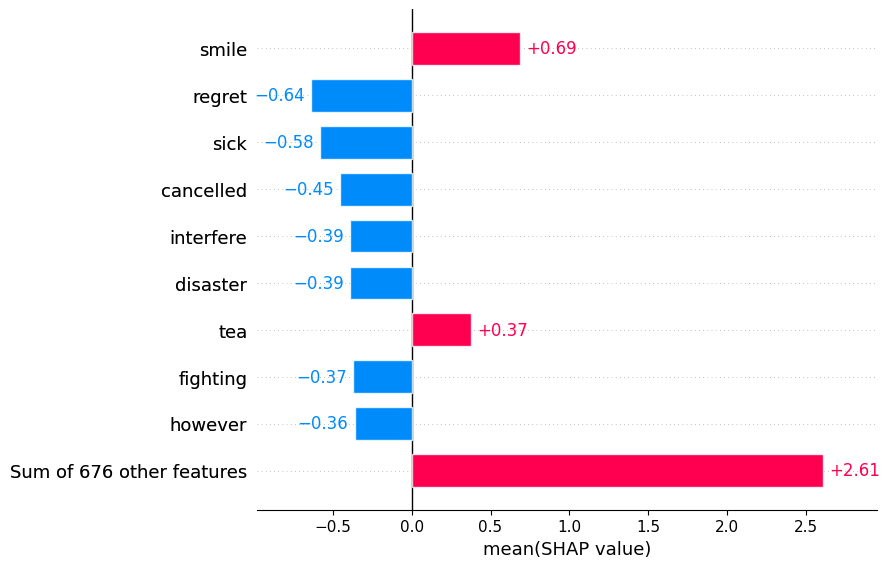

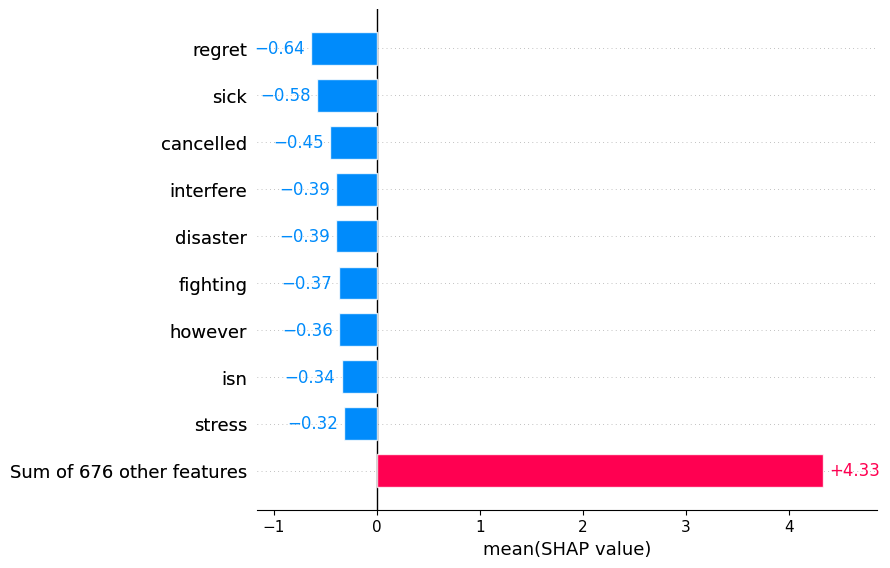

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
import shap

# Vérifier si CUDA est disponible et sélectionner le bon device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Charger le tokenizer BERT avec les tokens spéciaux
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
special_tokens = {'additional_special_tokens': ['[URL]', '[MENTION]', '[HASHTAG]']}
bert_tokenizer.add_special_tokens(special_tokens)

# Charger le modèle BERT fine-tuné et le déplacer vers le GPU si disponible
bert_model = BertForSequenceClassification.from_pretrained('./models/bert_model')
bert_model.to(device)

# Créer un pipeline pour la classification de sentiments en utilisant CUDA si disponible
bert_classifier = pipeline(
    "sentiment-analysis", 
    model=bert_model, 
    tokenizer=bert_tokenizer, 
    return_all_scores=True,
    device=0 if torch.cuda.is_available() else -1
)

# Charger les données
data = pd.read_csv('./data/001/sentiment140_cleaned.csv')

# Séparer les données en ensembles d'entraînement et de test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['cleaned_text'], data['target'], test_size=0.2, random_state=42, stratify=data['target']
)

# Limiter l'analyse aux tweets de l'ensemble de test
test_tweets = test_texts[:1000].tolist()

# SHAP - Créer un explainer en utilisant CUDA si disponible
explainer = shap.Explainer(bert_classifier)

# Expliquer les prédictions sur tous les tweets de l'ensemble de test (analyse locale + globale)
shap_values = explainer(test_tweets)

# --- Analyse locale pour les 3 premiers tweets ---
print("Analyse locale (SHAP text plot) pour les 3 premiers tweets :")
shap.plots.text(shap_values[:3])  # Visualiser les explications pour 3 tweets

# --- Analyse globale : Visualiser la moyenne des contributions des tokens ---
print("Analyse globale (SHAP bar plot) pour la classe positive (ou autre classe) :")
# Remplacer "positive" par l'indice ou la classe souhaitée, par exemple shap_values[:, :, 1] pour la classe 1
shap.plots.bar(shap_values[:, :, 1].mean(0))

# Visualiser les tokens ayant le plus d'impact (ordonné)
shap.plots.bar(shap_values[:, :, 1].mean(0), order=shap.Explanation.argsort)


/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Using device: cuda


/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
You are not running the flash-attention implementation, expect numerical differences.
  0%|          | 0/380 [00:00<?, ?it/s]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
PartitionExplainer explainer: 11it [06:55, 41.55s/it]                        

Analyse locale (SHAP text plot) pour les 3 premiers tweets :


Analyse globale (SHAP bar plot) pour la classe positive :


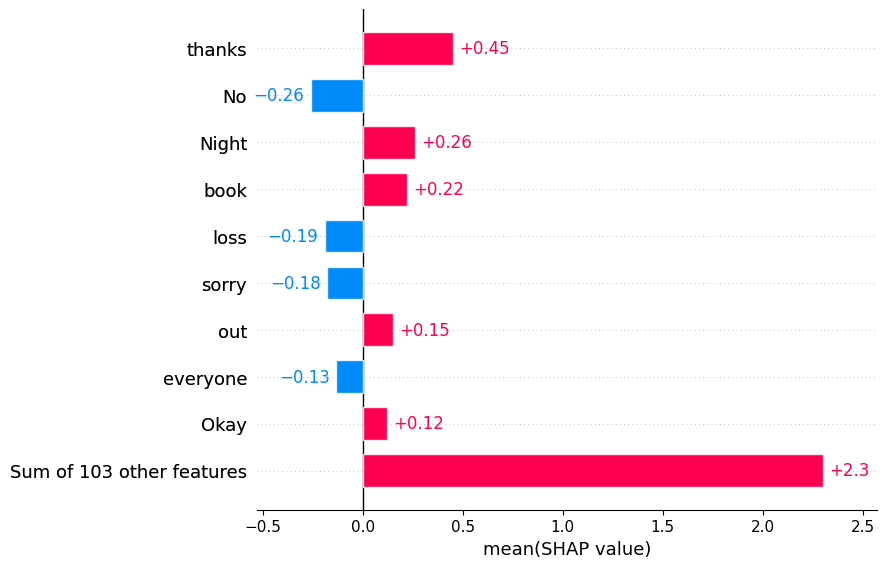

Tokens ayant le plus d'impact (ordonnés) :


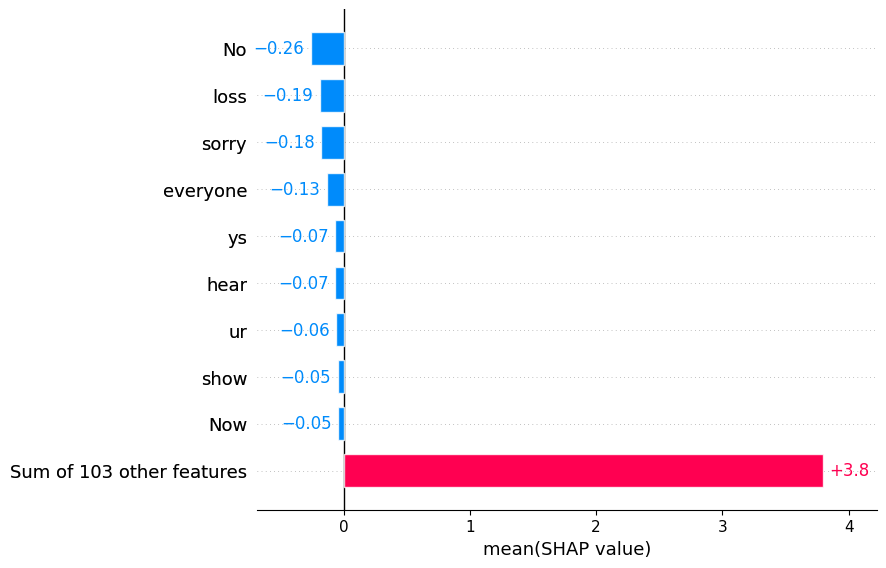

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from transformers import AutoTokenizer, pipeline,BitsAndBytesConfig,Phi3ForSequenceClassification
import shap

# Vérifier si CUDA est disponible et sélectionner le bon device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Chemin vers le modèle complet sauvegardé
model_path = './models/phi3_model_complete'

# Charger le tokenizer et le modèle complet
tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.pad_token = tokenizer.eos_token

# Chargement du modèle Phi-3 avec quantification 4-bit
model = Phi3ForSequenceClassification.from_pretrained(model_path)

# Créer un pipeline pour la classification de sentiments en utilisant CUDA si disponible
classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,
)

# Charger les données
data = pd.read_csv('./data/001/sentiment140_cleaned.csv')

# Séparer les données en ensembles d'entraînement et de test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['cleaned_text'], data['target'], test_size=0.2, random_state=42, stratify=data['target']
)

# Limiter l'analyse aux tweets de l'ensemble de test
test_tweets = test_texts[:10].tolist()

# SHAP - Créer un explainer en utilisant CUDA si disponible
explainer = shap.Explainer(classifier)

# Expliquer les prédictions sur tous les tweets de l'ensemble de test (analyse locale + globale)
shap_values = explainer(test_tweets)

# --- Analyse locale pour les 3 premiers tweets ---
print("Analyse locale (SHAP text plot) pour les 3 premiers tweets :")
shap.plots.text(shap_values[:3])  # Visualiser les explications pour 3 tweets

# --- Analyse globale : Visualiser la moyenne des contributions des tokens ---
print("Analyse globale (SHAP bar plot) pour la classe positive :")
shap.plots.bar(shap_values[:, :, 1].mean(0))

# Visualiser les tokens ayant le plus d'impact (ordonné)
print("Tokens ayant le plus d'impact (ordonnés) :")
shap.plots.bar(shap_values[:, :, 1].mean(0), order=shap.Explanation.argsort)

# Libérer les ressources liées au modèle et à CUDA
del model
del classifier
del explainer
del shap_values

# Vider le cache CUDA pour libérer la VRAM
torch.cuda.empty_cache()